In [21]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr
import math as math
from scipy.optimize import curve_fit
import seaborn as sns
import random as random

from netCDF4 import Dataset
import h5py

plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_13424\3947057954.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
dsm  = xr.open_dataset('eqcross_mv05iv06_r00_mti_2021 (1).nc')
dsi  = xr.open_dataset('eqcross_mv05iv06_r00_ivm_2021.nc')

dsi = dsi.load()

C:\Users\pkoll\anaconda3\lib\site-packages\ecmwflibs\__init__.py:83: UserWarning: DLL load failed while importing _ecmwflibs: The specified procedure could not be found.
  warnings.warn(str(e))
C:\Users\pkoll\anaconda3\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## With MIGHTI V and IVM drift_mer

In [4]:
dm0 = dsm[['u','v', 'q']].sel(dt=0).isel(alt=slice(2,-2)) # Only u, v variables, but also quality (q) variable for possible later filtering
di0 = dsi[['drift_mer','slt', 'time', 'dm_flag', 'rpa_flag']].sel(dt=0) # only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)

d = xr.merge((dm0, di0))
d = d.dropna(dim='num', how='any', subset=['u','drift_mer']) # Drop missing data

# Only keep later LTs and data where the ivm quality flag is good
d = d.where((d.slt > 11) & (d.slt < 16) & (d.q.mean(dim='alt') > 0.95) & (d.dm_flag == 0) & (d.rpa_flag == 0), drop=True)


In [5]:
d

<xarray.Dataset>
Dimensions:    (num: 1388, alt: 80)
Coordinates:
  * alt        (alt) float64 94.28 97.21 100.1 103.1 ... 293.1 295.4 297.7 300.0
    dt         float64 0.0
  * num        (num) int64 10 11 21 22 24 25 ... 7572 7576 7577 7582 7584 7586
Data variables:
    u          (num, alt) float64 -69.47 -34.12 15.9 ... -4.583 -10.62 -16.63
    v          (num, alt) float64 89.09 113.0 87.61 22.67 ... 78.85 86.1 93.33
    q          (num, alt) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    drift_mer  (num) float64 -1.099 -0.84 3.109 -5.834 ... 21.11 26.76 22.95
    slt        (num) float32 15.88 15.69 15.85 15.91 ... 15.85 15.99 15.92 15.89
    time       (num) datetime64[ns] 2021-01-01T14:41:48.128000 ... 2021-12-31...
    dm_flag    (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rpa_flag   (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [6]:
# This will save all of the changes between the pairs.

delta_t_hr = [] 
delta_alt = [] 
delta_u = [] 
delta_v = []
delta_drift_mer = []
delta_slt = [] 

#dsi0 = d.sel(dt=0) # Only need to consider central timestamp for each crossing (dt=0) - DONE ABOVE

for i in range(len(d.num)):
    # Status indicator
    if np.mod(i,10) == 0:
        print('%i / %i' % (i, len(d.num)))
    
    ds1 = d.isel(num=i)
    
    # Grab all other timestamps that are 24-24.15 hours in the future, collect them in dataset ds2, which is a subset of the full dataset
    delta_t = d.time - ds1.time 
    happens_soon_after = (delta_t > pd.to_timedelta('24h')) & (delta_t < pd.to_timedelta('24.15h'))
    ds2 = d.where(happens_soon_after, drop=True)
        
    # Record some parameters of interest.
    #delta_t_hr.extend(pd.to_timedelta(ds2.time - ds1.time).total_seconds()/3600.)
    #delta_alt.extend(ds2.alt - ds1.alt)
    delta_u.extend(ds2.u - ds1.u)
    delta_v.extend(ds2.v - ds1.v)

    delta_drift_mer.extend(ds2.drift_mer - ds1.drift_mer)
    #delta_slt.extend(np.mod(ds2.slt - ds1.slt + 12, 24) - 12) # Similar for local times (-12 to +12)
    
#delta_t_hr = np.array(delta_t_hr) #should all be between 24-24.15
#delta_alt = np.array(delta_alt) #should all be 0
delta_u = np.array(delta_u)
delta_v = np.array(delta_v)
delta_drift_mer = np.array(delta_drift_mer)
#delta_slt = np.array(delta_slt) #not really needed for analysis

0 / 1388
10 / 1388
20 / 1388
30 / 1388
40 / 1388
50 / 1388
60 / 1388
70 / 1388
80 / 1388
90 / 1388
100 / 1388
110 / 1388
120 / 1388
130 / 1388
140 / 1388
150 / 1388
160 / 1388
170 / 1388
180 / 1388
190 / 1388
200 / 1388
210 / 1388
220 / 1388
230 / 1388
240 / 1388
250 / 1388
260 / 1388
270 / 1388
280 / 1388
290 / 1388
300 / 1388
310 / 1388
320 / 1388
330 / 1388
340 / 1388
350 / 1388
360 / 1388
370 / 1388
380 / 1388
390 / 1388
400 / 1388
410 / 1388
420 / 1388
430 / 1388
440 / 1388
450 / 1388
460 / 1388
470 / 1388
480 / 1388
490 / 1388
500 / 1388
510 / 1388
520 / 1388
530 / 1388
540 / 1388
550 / 1388
560 / 1388
570 / 1388
580 / 1388
590 / 1388
600 / 1388
610 / 1388
620 / 1388
630 / 1388
640 / 1388
650 / 1388
660 / 1388
670 / 1388
680 / 1388
690 / 1388
700 / 1388
710 / 1388
720 / 1388
730 / 1388
740 / 1388
750 / 1388
760 / 1388
770 / 1388
780 / 1388
790 / 1388
800 / 1388
810 / 1388
820 / 1388
830 / 1388
840 / 1388
850 / 1388
860 / 1388
870 / 1388
880 / 1388
890 / 1388
900 / 1388
910 / 1388

In [7]:
d.time == ds1.time

<xarray.DataArray 'time' (num: 1388)>
array([False, False, False, ..., False, False,  True])
Coordinates:
    dt       float64 0.0
  * num      (num) int64 10 11 21 22 24 25 28 ... 7572 7576 7577 7582 7584 7586

In [8]:
delta_t

<xarray.DataArray 'time' (num: 1388)>
array([-31442760184000000, -31437020224000000, -31384879604000000, ...,
          -11548889000000,     -5778945000000,                  0],
      dtype='timedelta64[ns]')
Coordinates:
    dt       float64 0.0
  * num      (num) int64 10 11 21 22 24 25 28 ... 7572 7576 7577 7582 7584 7586

In [9]:
np.shape(delta_u)

(1057, 80)

In [10]:
df_u = pd.DataFrame(delta_u)
df_v = pd.DataFrame(delta_v)
df_drift_mer = pd.DataFrame(delta_drift_mer)

In [11]:
df_v

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,34.067974,-53.118271,-91.669936,-120.564509,-45.875995,69.880772,95.938963,79.147086,-36.257926,-74.290753,...,35.629900,42.688222,48.407610,52.650522,56.880207,61.096705,60.268479,53.257695,46.268768,39.301628
1,-25.804468,36.432900,-6.986714,-41.185048,-43.083366,-29.017227,-17.647942,11.640018,5.620679,94.783226,...,-35.648423,-47.782068,-42.460973,-17.865287,6.653722,31.096294,40.293623,30.815526,21.366978,11.947885
2,-30.197108,5.038725,28.183855,28.702797,8.243909,9.446422,36.918837,-5.453605,-21.851496,-11.433783,...,-25.480219,-31.328880,-36.902140,-42.173185,-47.427797,-52.666028,-53.856667,-50.088110,-46.331301,-42.586203
3,24.508675,5.869452,-27.364962,-79.888665,-75.509800,-55.852249,-26.658887,-3.953066,-34.461386,28.031179,...,-11.779375,-9.808173,-11.947945,-18.627603,-25.286437,-31.924512,-33.992419,-30.461375,-26.941339,-23.432277
4,3.073850,-7.180119,9.407054,25.091110,22.175361,-22.265259,-28.601859,-40.164385,11.556695,41.094238,...,-29.029420,-31.316265,-34.304155,-38.067112,-41.818338,-45.557870,-45.394503,-40.448285,-35.517486,-30.602058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,126.931827,21.926003,-92.517774,-120.109648,-44.111701,-11.527730,-16.716019,3.379510,-6.920943,1.995190,...,-21.063921,-18.018069,-13.462372,-7.238039,-1.033111,5.152474,6.445585,1.744229,-2.942471,-7.614560
1053,15.804354,57.102495,35.607904,5.285748,18.751274,36.050745,50.063945,40.583039,7.966361,-26.039354,...,56.118007,62.513312,63.015074,57.009599,51.022845,45.054756,40.095974,36.370485,32.656610,28.954314
1054,-116.427591,-71.834839,5.075216,65.868698,71.076328,21.932015,-56.968179,-102.941146,-151.412323,-167.063488,...,19.364968,19.855129,15.497156,5.784611,-3.897655,-13.549737,-17.451452,-14.309276,-11.176895,-8.054280
1055,-127.565084,-51.663835,46.312619,115.344308,66.976307,-11.501211,-77.808810,-58.850946,-19.339837,-0.648280,...,9.902249,7.605461,0.225574,-12.769337,-25.723736,-38.637750,-42.624994,-35.675944,-28.748557,-21.842767


In [12]:
df_X = df_u
for i in range(0,80):
    df_X[79+i] = df_v[i]

In [13]:
df_X

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,126.221382,6.091295,2.758862,-14.940486,-15.371595,-11.957402,-4.856908,-61.107597,22.700260,28.159544,...,35.629900,42.688222,48.407610,52.650522,56.880207,61.096705,60.268479,53.257695,46.268768,39.301628
1,55.951002,58.068511,24.181075,-56.006532,21.616283,-15.907028,0.836305,-36.686277,-34.947794,3.788452,...,-35.648423,-47.782068,-42.460973,-17.865287,6.653722,31.096294,40.293623,30.815526,21.366978,11.947885
2,-87.252663,27.694339,63.928431,38.568724,43.764846,41.207163,73.197271,67.666153,44.883293,60.049980,...,-25.480219,-31.328880,-36.902140,-42.173185,-47.427797,-52.666028,-53.856667,-50.088110,-46.331301,-42.586203
3,49.266178,38.853897,25.929757,-8.266624,-40.623964,-50.699713,-6.303042,23.624407,-35.322672,6.525582,...,-11.779375,-9.808173,-11.947945,-18.627603,-25.286437,-31.924512,-33.992419,-30.461375,-26.941339,-23.432277
4,50.051284,3.383523,7.355206,19.019079,0.645595,-26.656854,-37.507926,-41.825795,-52.838610,-13.510464,...,-29.029420,-31.316265,-34.304155,-38.067112,-41.818338,-45.557870,-45.394503,-40.448285,-35.517486,-30.602058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,46.485234,20.202256,-4.133196,-9.960455,8.211468,85.374328,99.816027,23.669067,-61.154182,-90.388087,...,-21.063921,-18.018069,-13.462372,-7.238039,-1.033111,5.152474,6.445585,1.744229,-2.942471,-7.614560
1053,54.182358,41.586132,-16.669493,-43.634285,-10.683799,21.258191,53.013611,39.177949,16.404002,18.992216,...,56.118007,62.513312,63.015074,57.009599,51.022845,45.054756,40.095974,36.370485,32.656610,28.954314
1054,-12.495078,-22.764614,-39.903827,-54.955758,-31.748170,-1.355824,-28.690046,-53.144782,-48.080377,-18.827789,...,19.364968,19.855129,15.497156,5.784611,-3.897655,-13.549737,-17.451452,-14.309276,-11.176895,-8.054280
1055,-37.249705,-18.287356,16.840027,38.397462,51.485381,-3.772723,-30.684593,-30.841193,15.767484,20.112259,...,9.902249,7.605461,0.225574,-12.769337,-25.723736,-38.637750,-42.624994,-35.675944,-28.748557,-21.842767


### PCA

#### WITH BOTH

In [17]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_X
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)

X_reduced_train = sc.transform(X_train)
X_reduced_test = sc.transform(X_test)


pca = PCA()
pca.fit(X_reduced_train)

X_train_pca = pca.transform(X_reduced_train)
X_test_pca = pca.transform(X_reduced_test)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_pca, y_train)

y_pred_test_pca = model.predict(X_test_pca)
y_pred_train_pca = model.predict(X_train_pca)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_pred_train_pca)
r2_test = r2_score(y_test, y_pred_test_pca)

print(r2_train,r2_test)

0.45307391548999376 0.2346896881857502


<IPython.core.display.Javascript object>


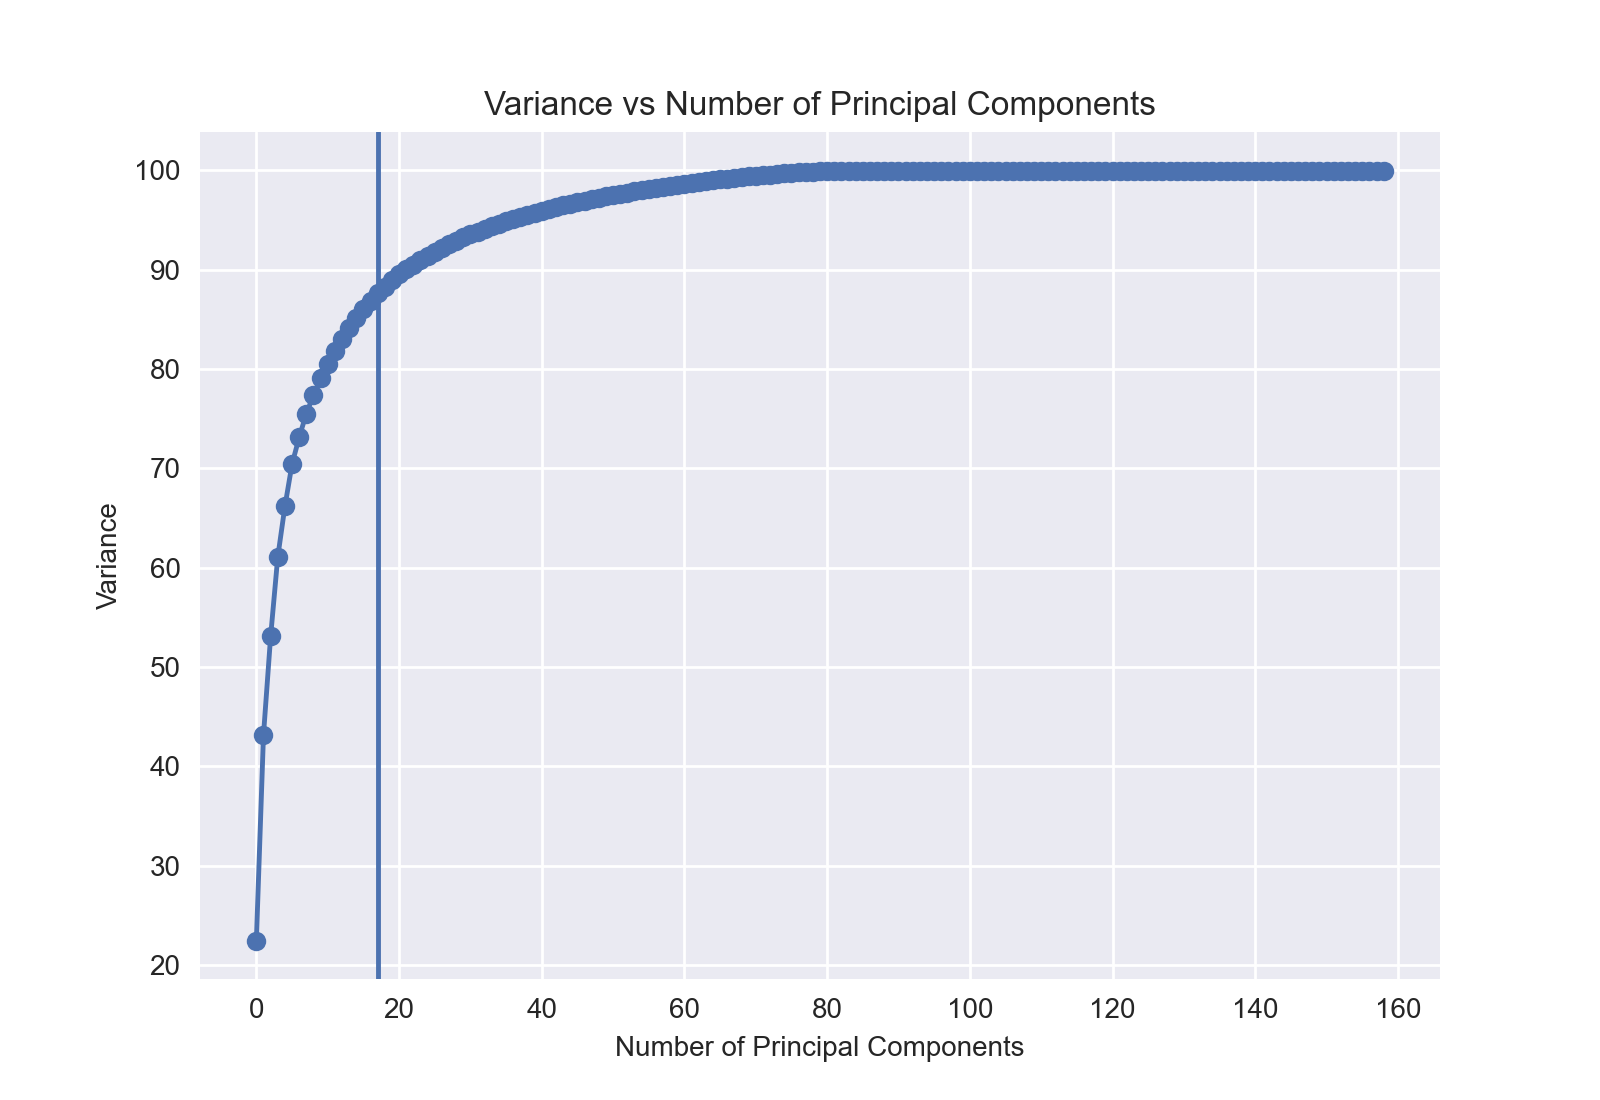

In [18]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)

plt.figure()
plt.plot(var, '-o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.title('Variance vs Number of Principal Components') 
plt.axvline(17)
plt.show()

<IPython.core.display.Javascript object>


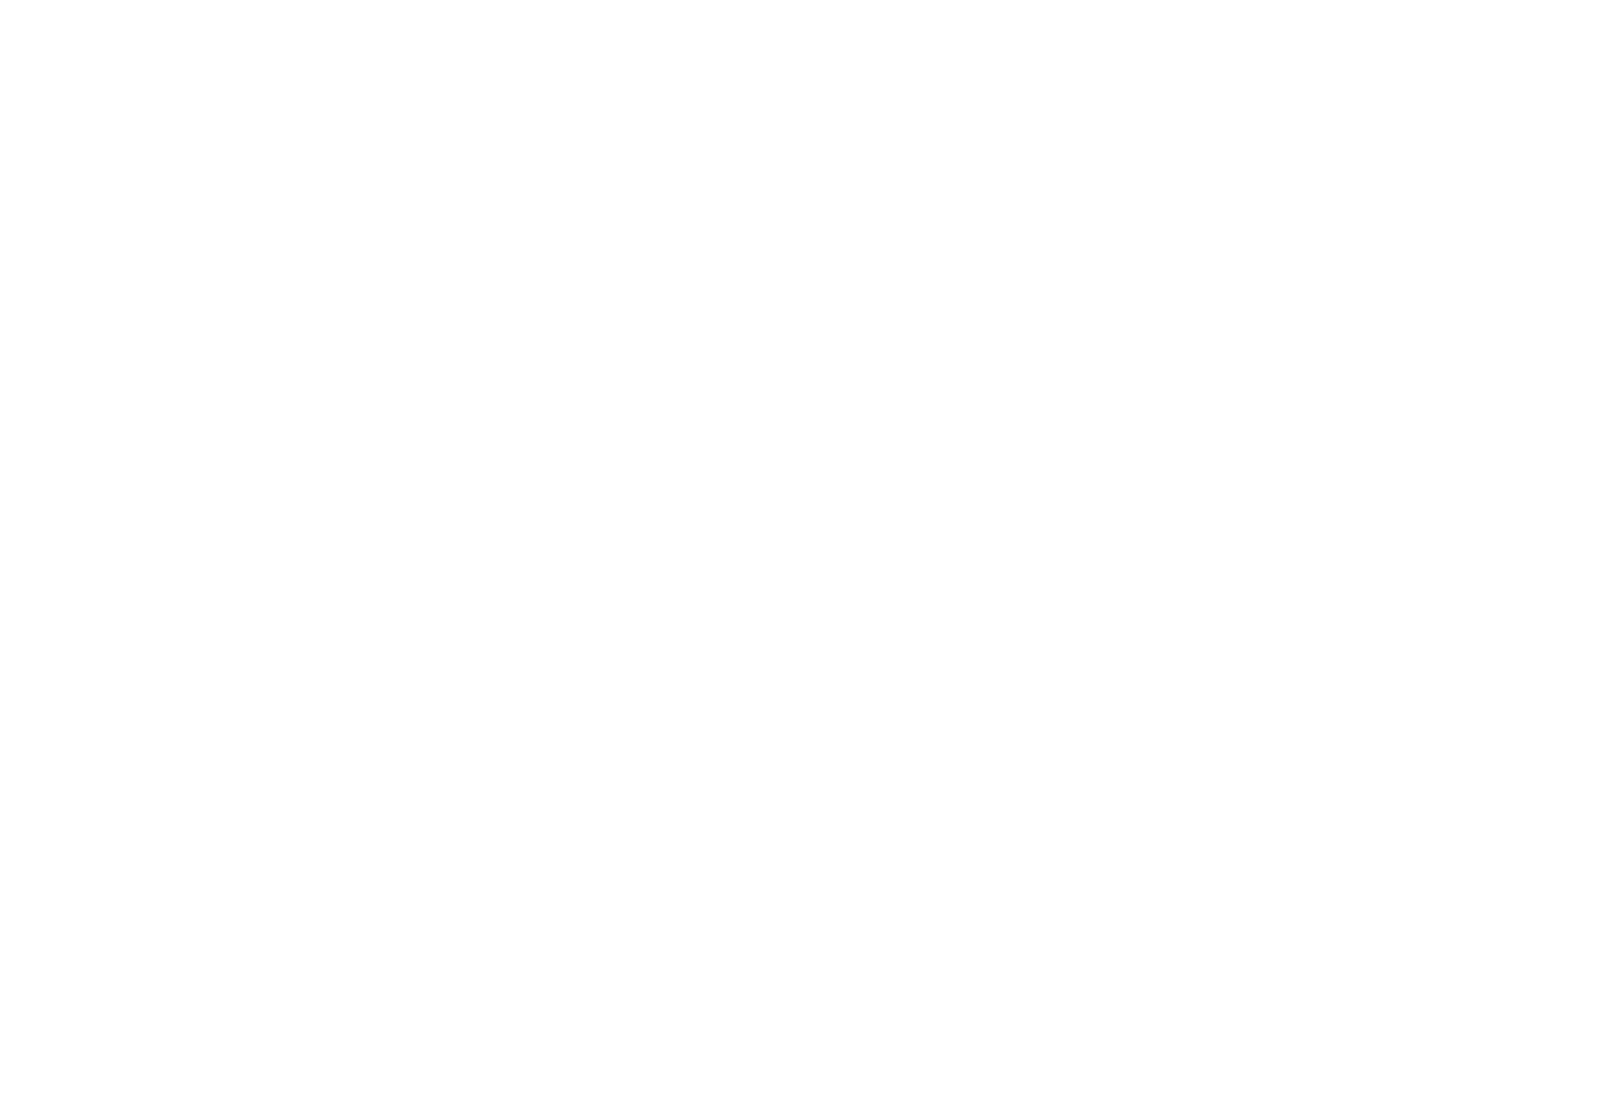

In [19]:
#PC PLOT VS TEST AND TRAIN

def pcs(n):
    
    pca = PCA(n_components= n)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_reduced_train)
    X_test_pca = pca.transform(X_reduced_test)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train_pca, y_train)

    y_pred_test_pca = model.predict(X_test_pca)
    y_pred_train_pca = model.predict(X_train_pca)

    from sklearn.metrics import r2_score
    r2_train = r2_score(y_train, y_pred_train_pca)
    r2_test = r2_score(y_test, y_pred_test_pca)

    return r2_train,r2_test

train_r2s = []
test_r2s = []
component_num = []

for i in range(1,160):
    r2 = pcs(i)
    train_r2s.append(r2[0])
    test_r2s.append(r2[1])
    component_num.append(i)
    
plt.figure()
plt.title('PC Components vs R^2 for Training and Test Set')
plt.plot(component_num,train_r2s,label = 'Training Set')
plt.plot(component_num,test_r2s, label = 'Test Set')
plt.xlabel('Component')
plt.ylabel('R^2')
plt.axvline(17)
plt.legend()
plt.show() 

#### With Error Bars

In [22]:
#Train Test Split

train_means = []
test_means = []
train_stdevs = []
test_stdevs = []
n_comps = []

for n in range(1,160):
    train_r2s = []
    test_r2s = []
    
    for i in range(0,100):
        t = random.uniform(0.1,0.5)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= t)

        #sc = StandardScaler()
        #sc.fit(X_train)
        #sc.fit(X_test)

        #X_reduced_train = sc.transform(X_train)
        #X_reduced_test = sc.transform(X_test)


        pca = PCA(n_components = n)
        pca.fit(X_train)

        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)

        model = LinearRegression(fit_intercept=True)
        model.fit(X_train_pca, y_train)

        y_pred_test_pca = model.predict(X_test_pca)
        y_pred_train_pca = model.predict(X_train_pca)

        from sklearn.metrics import r2_score
        r2_train = r2_score(y_train, y_pred_train_pca)
        r2_test = r2_score(y_test, y_pred_test_pca)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)
        
        i+= 1

    train_means.append(np.mean(train_r2s))
    train_stdevs.append(np.std(train_r2s))
    
    test_means.append(np.mean(test_r2s))
    test_stdevs.append(np.std(test_r2s))
    n_comps.append(n)
    
    train_r2s = []
    test_r2s = []
    
    
    print(n)
    n += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


<IPython.core.display.Javascript object>


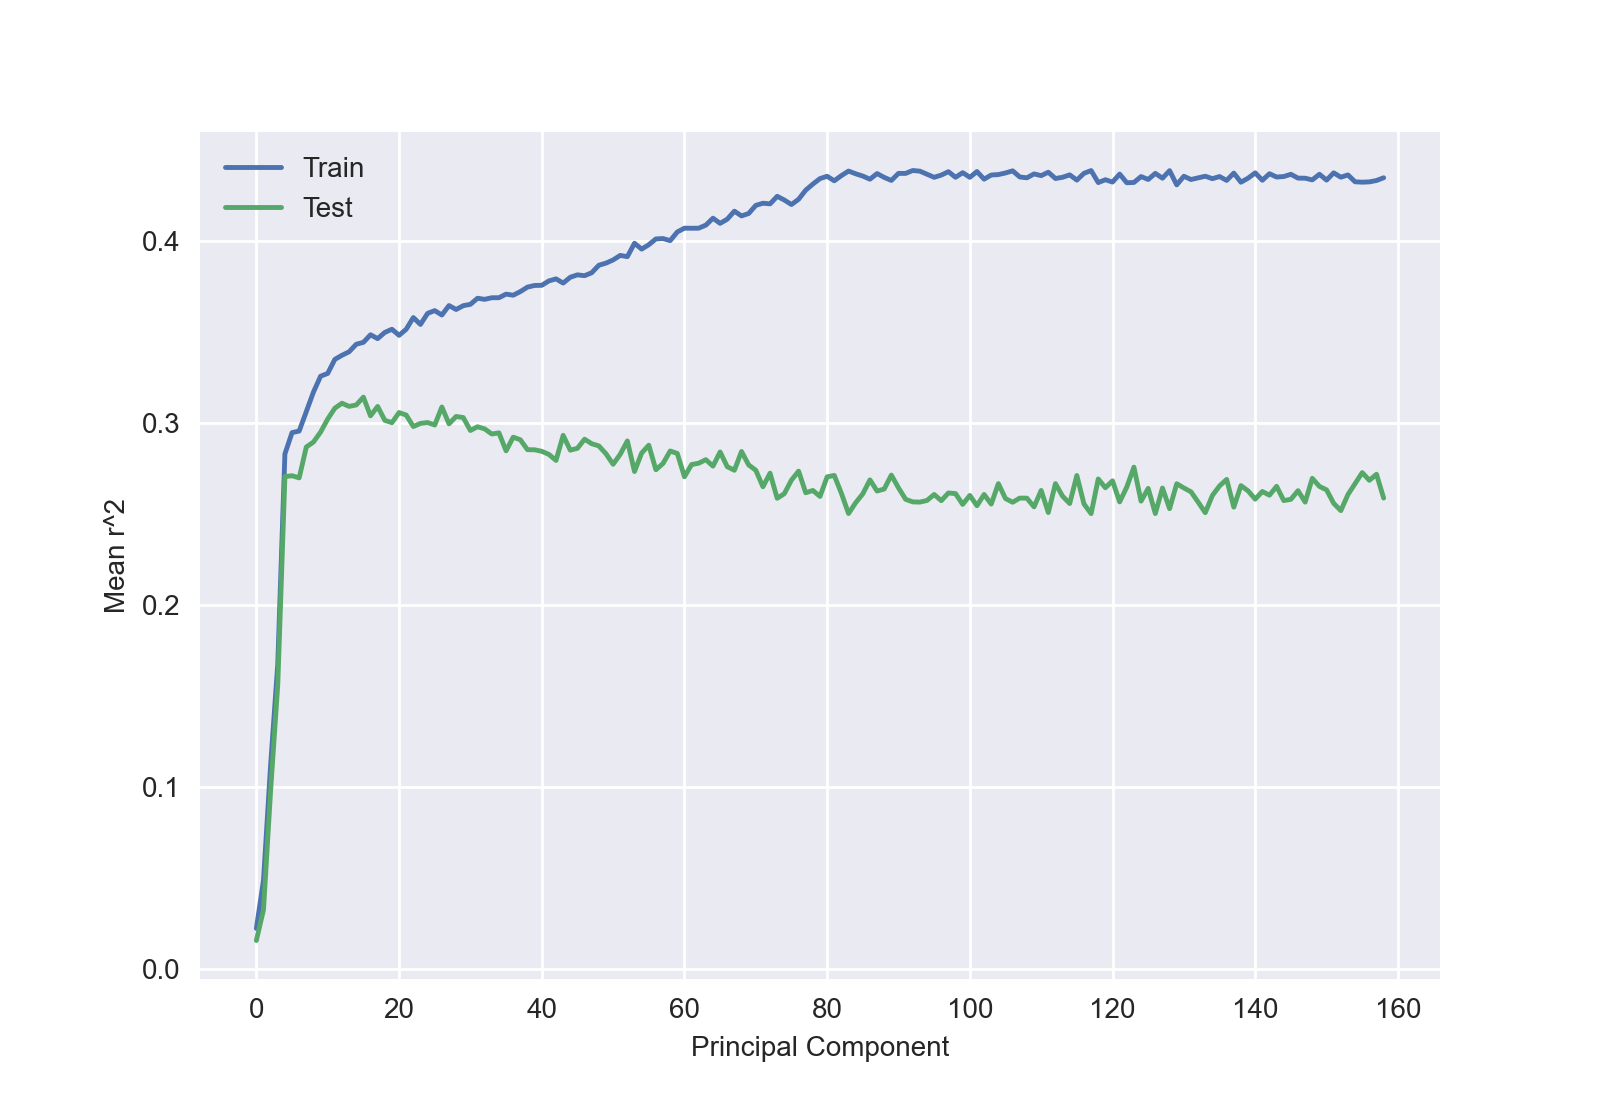

In [25]:
plt.figure()
plt.plot(train_means,label ='Train')
plt.plot(test_means, label = 'Test')
plt.xlabel('Principal Component')
plt.ylabel('Mean r^2')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


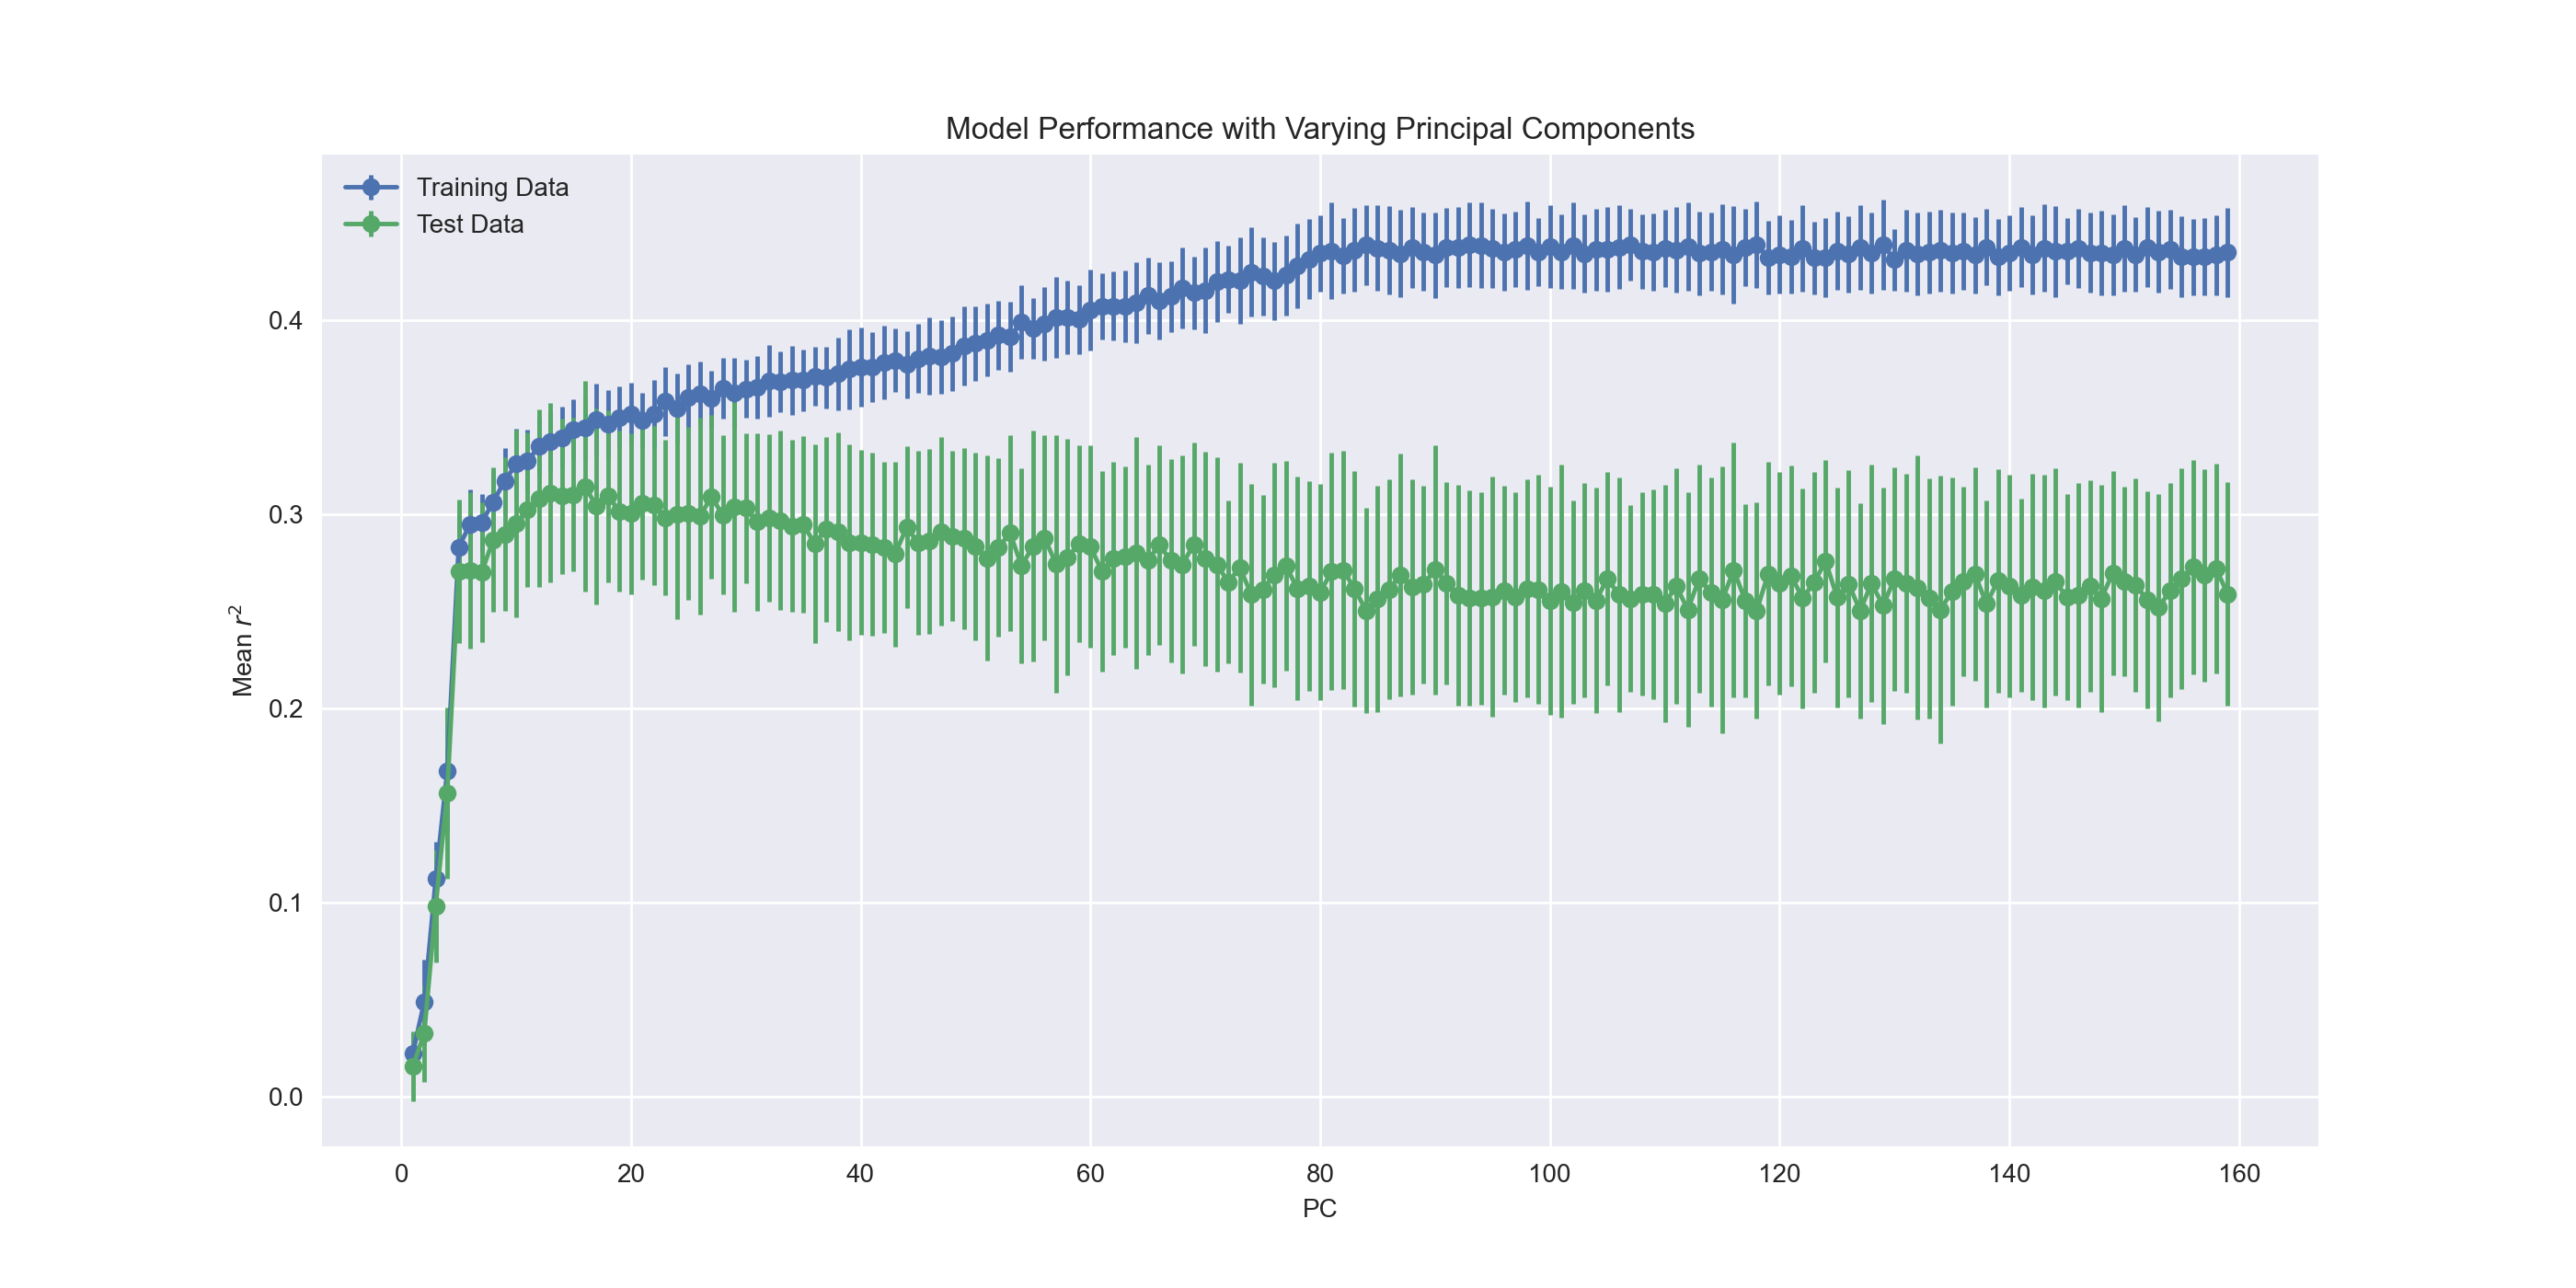

In [30]:
x = n_comps
y = train_means
y2 = test_means
yerr = train_stdevs
y2_err = test_stdevs

fig, ax = plt.subplots(figsize = (14,7))


ax.errorbar(x, y,
            yerr= yerr,
            fmt='-o',label = 'Training Data')


ax.errorbar(x, y2,
            yerr= y2_err,
            fmt='-o', label = "Test Data")

ax.set_xlabel('PC')
ax.set_ylabel('Mean $ r^2 $')
ax.set_title('Model Performance with Varying Principal Components')
plt.legend()
plt.show()
plt.savefig('Model_Performance_PCs_with_MER.png')


#### WITH JUST MERIDIONAL WINDS

In [12]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_v
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)

X_reduced_train = sc.transform(X_train)
X_reduced_test = sc.transform(X_test)


pca = PCA()
pca.fit(X_reduced_train)

X_train_pca = pca.transform(X_reduced_train)
X_test_pca = pca.transform(X_reduced_test)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_pca, y_train)

y_pred_test_pca = model.predict(X_test_pca)
y_pred_train_pca = model.predict(X_train_pca)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_pred_train_pca)
r2_test = r2_score(y_test, y_pred_test_pca)

print(r2_train,r2_test)

0.2190460034981797 0.19349314045082866


In [31]:
### WITH BOTH U AND V

<IPython.core.display.Javascript object>


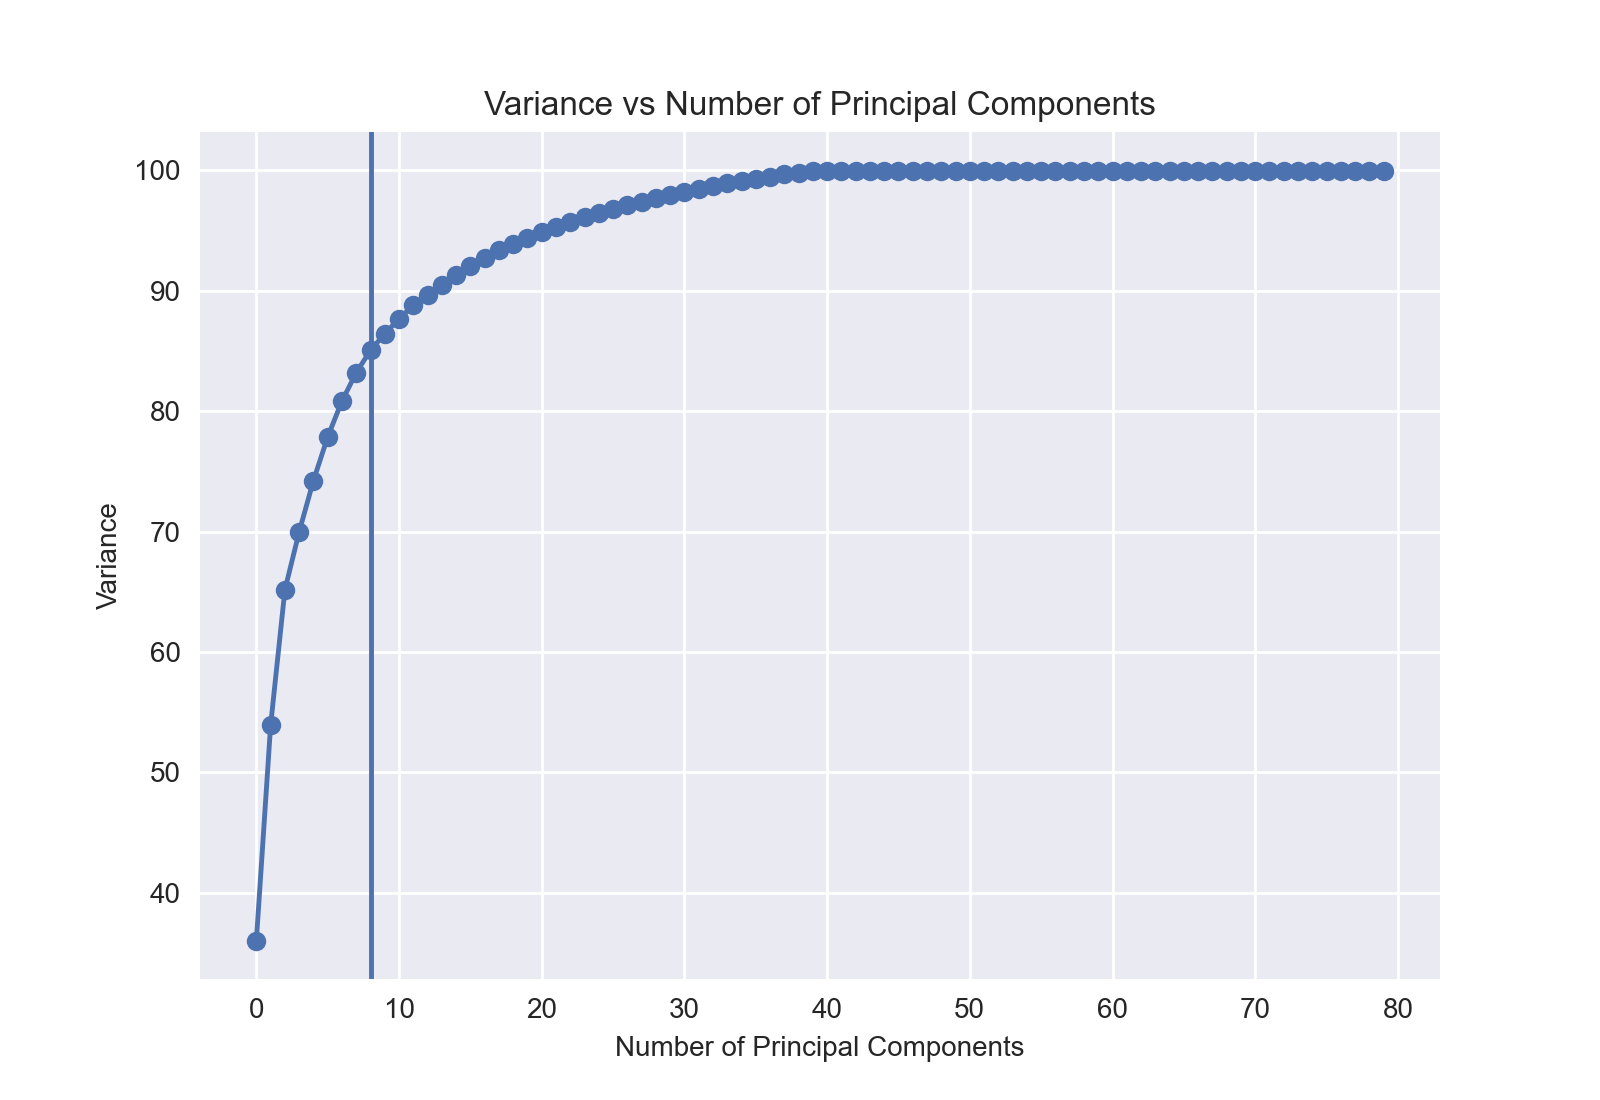

In [80]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)

plt.figure()
plt.plot(var, '-o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.title('Variance vs Number of Principal Components') 
plt.axvline(8)
plt.show()

<IPython.core.display.Javascript object>


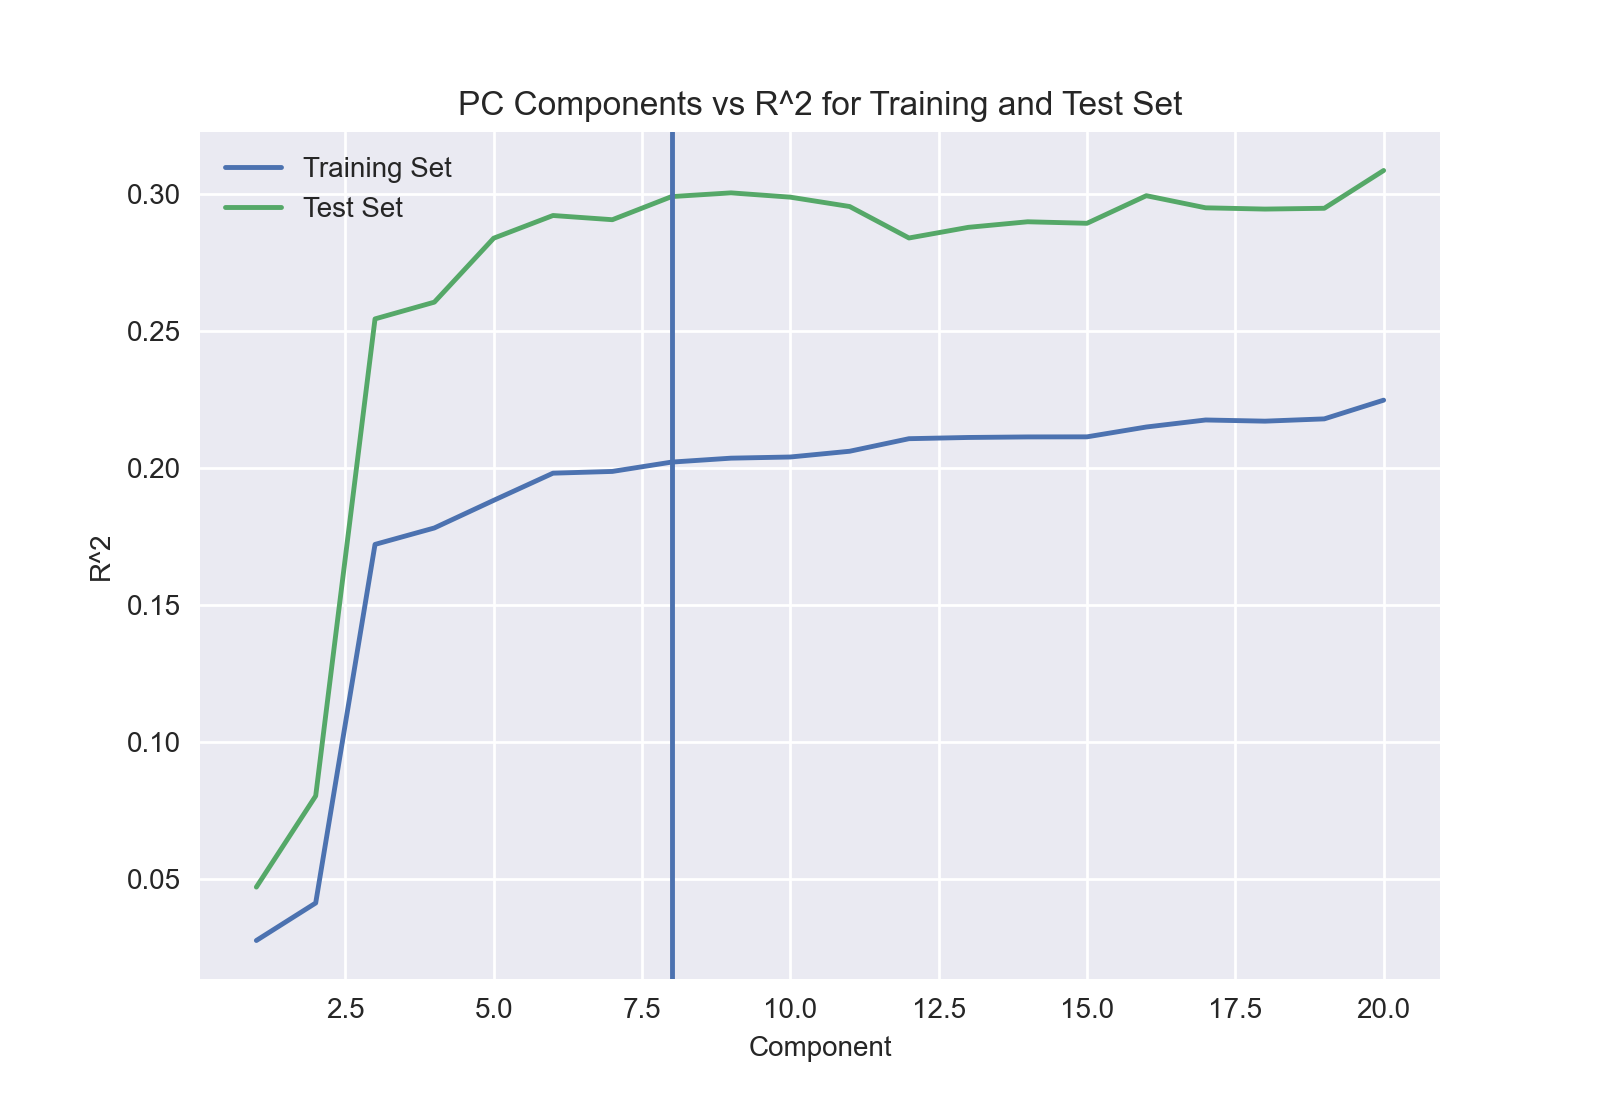

In [81]:
#PC PLOT VS TEST AND TRAIN

def pcs(n):
    
    pca = PCA(n_components= n)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_reduced_train)
    X_test_pca = pca.transform(X_reduced_test)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train_pca, y_train)

    y_pred_test_pca = model.predict(X_test_pca)
    y_pred_train_pca = model.predict(X_train_pca)

    from sklearn.metrics import r2_score
    r2_train = r2_score(y_train, y_pred_train_pca)
    r2_test = r2_score(y_test, y_pred_test_pca)

    return r2_train,r2_test

train_r2s = []
test_r2s = []
component_num = []

for i in range(1,21):
    r2 = pcs(i)
    train_r2s.append(r2[0])
    test_r2s.append(r2[1])
    component_num.append(i)
    
plt.figure()
plt.title('PC Components vs R^2 for Training and Test Set')
plt.plot(component_num,train_r2s,label = 'Training Set')
plt.plot(component_num,test_r2s, label = 'Test Set')
plt.xlabel('Component')
plt.ylabel('R^2')
plt.axvline(8)
plt.legend()
plt.show() 

In [83]:
#From the plots, the 8th PC seems the most effective. Using this...

X = df_u
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)



#WITHOUT PCA
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
print('Intercept (no PCA) = ', model.intercept_)
print('Coefficients (no PCA)=', model.coef_)



#WITH PCA
pca = PCA(n_components = 8)
pca.fit(X_reduced_train)

X_train_pca = pca.transform(X_reduced_train)
X_test_pca = pca.transform(X_reduced_test)

lin_reg_pc = LinearRegression(fit_intercept=True)
lin_reg_pc.fit(X_train_pca, y_train)

#y_pred_test_pca = lin_reg_pc.predict(X_test_pca)
#y_pred_train_pca = lin_reg_pc.predict(X_train_pca)

print('Intercept (PCA) = ', lin_reg_pc.intercept_)
print('Coefficients (PCA)=', lin_reg_pc.coef_)




Intercept (no PCA) =  [-0.13508885]
Coefficients (no PCA)= [[ 1.49163141e-02 -2.47698060e-02 -1.36549649e-02 -2.00044290e-02
   7.06143527e-03 -1.19810159e-02 -5.70542972e-02 -1.23369215e-02
   1.72624464e-02  5.96785619e-03  2.72594458e-02 -2.48478438e-02
  -1.06174807e-02  3.88259056e-02  4.14760737e-02 -5.35072406e-02
  -1.86213584e-02 -2.79601096e-03 -1.96534106e-02  6.67600167e-02
   6.47213467e-02 -8.73715520e-03  4.07408429e-02 -3.65834197e-02
   7.13962768e-03  9.72502864e-03 -7.26919167e-03  1.81337889e-02
   2.92252086e+10 -9.55996421e+09 -5.53869420e+10 -6.96647440e+09
   5.10236266e+10 -4.61610037e+10  8.41789320e+10 -8.01326243e+09
  -4.17878667e+10  3.58381394e+10 -7.23430222e+10 -2.66292033e+09
  -2.47993737e+10  9.46614644e+10  2.76266195e+10 -1.80776569e+10
  -1.46349854e+10  1.26883111e+09 -8.17450487e+10  3.02557421e+10
  -1.46032544e+10  3.03769520e+10  7.13455484e+10 -2.60754559e+10
  -1.48102650e+10 -4.94449583e+10  1.03281470e+10  5.43770030e+10
  -7.91846533e+10

In [84]:
#PREDICTIONS

#NO PCA
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

#PCA
y_pred_test_pca = lin_reg_pc.predict(X_test_pca)
y_pred_train_pca = lin_reg_pc.predict(X_train_pca)

In [85]:
#ERRORS

#NO PCA
train_rmse = np.sqrt(np.mean((y_train-y_pred_train)**2,axis = 0))
test_rmse = np.sqrt(np.mean((y_test-y_pred_test)**2,axis = 0))

print('Train RMSE (no PCA):',train_rmse[0])
print('Test RMSE (no PCA):' ,test_rmse[0])

#PCA

pca_train_rmse = np.sqrt(np.mean((y_train-y_pred_train_pca)**2, axis = 0))
pca_test_rmse = np.sqrt(np.mean((y_test-y_pred_test_pca)**2, axis = 0))

print('Train RMSE (PCA):',pca_train_rmse[0])
print('Test RMSE (PCA):' ,pca_test_rmse[0])


Train RMSE (no PCA): 9.316899984382669
Test RMSE (no PCA): 9.35010338384878
Train RMSE (PCA): 9.74936070129956
Test RMSE (PCA): 8.940720340851646


In [86]:
#r2 Values
from sklearn.metrics import r2_score
r2_train_sk = r2_score(y_train, y_pred_train)
r2_test_sk = r2_score(y_test, y_pred_test)

print('r^2 for Training Set Using SKLearn (no PCA)', r2_train_sk)
print('r^2 for Test Set Using SKLearn (no PCA)', r2_test_sk)

r2_train_sk_pca = r2_score(y_train, y_pred_train_pca)
r2_test_sk_pca = r2_score(y_test, y_pred_test_pca)

print('r^2 for Training Set Using SKLearn PCA', r2_train_sk_pca)
print('r^2 for Test Set Using SKLearn PCA', r2_test_sk_pca)


r^2 for Training Set Using SKLearn (no PCA) 0.27227882855636765
r^2 for Test Set Using SKLearn (no PCA) 0.23269009502656135
r^2 for Training Set Using SKLearn PCA 0.2031539575775816
r^2 for Test Set Using SKLearn PCA 0.29841063042557636


<IPython.core.display.Javascript object>


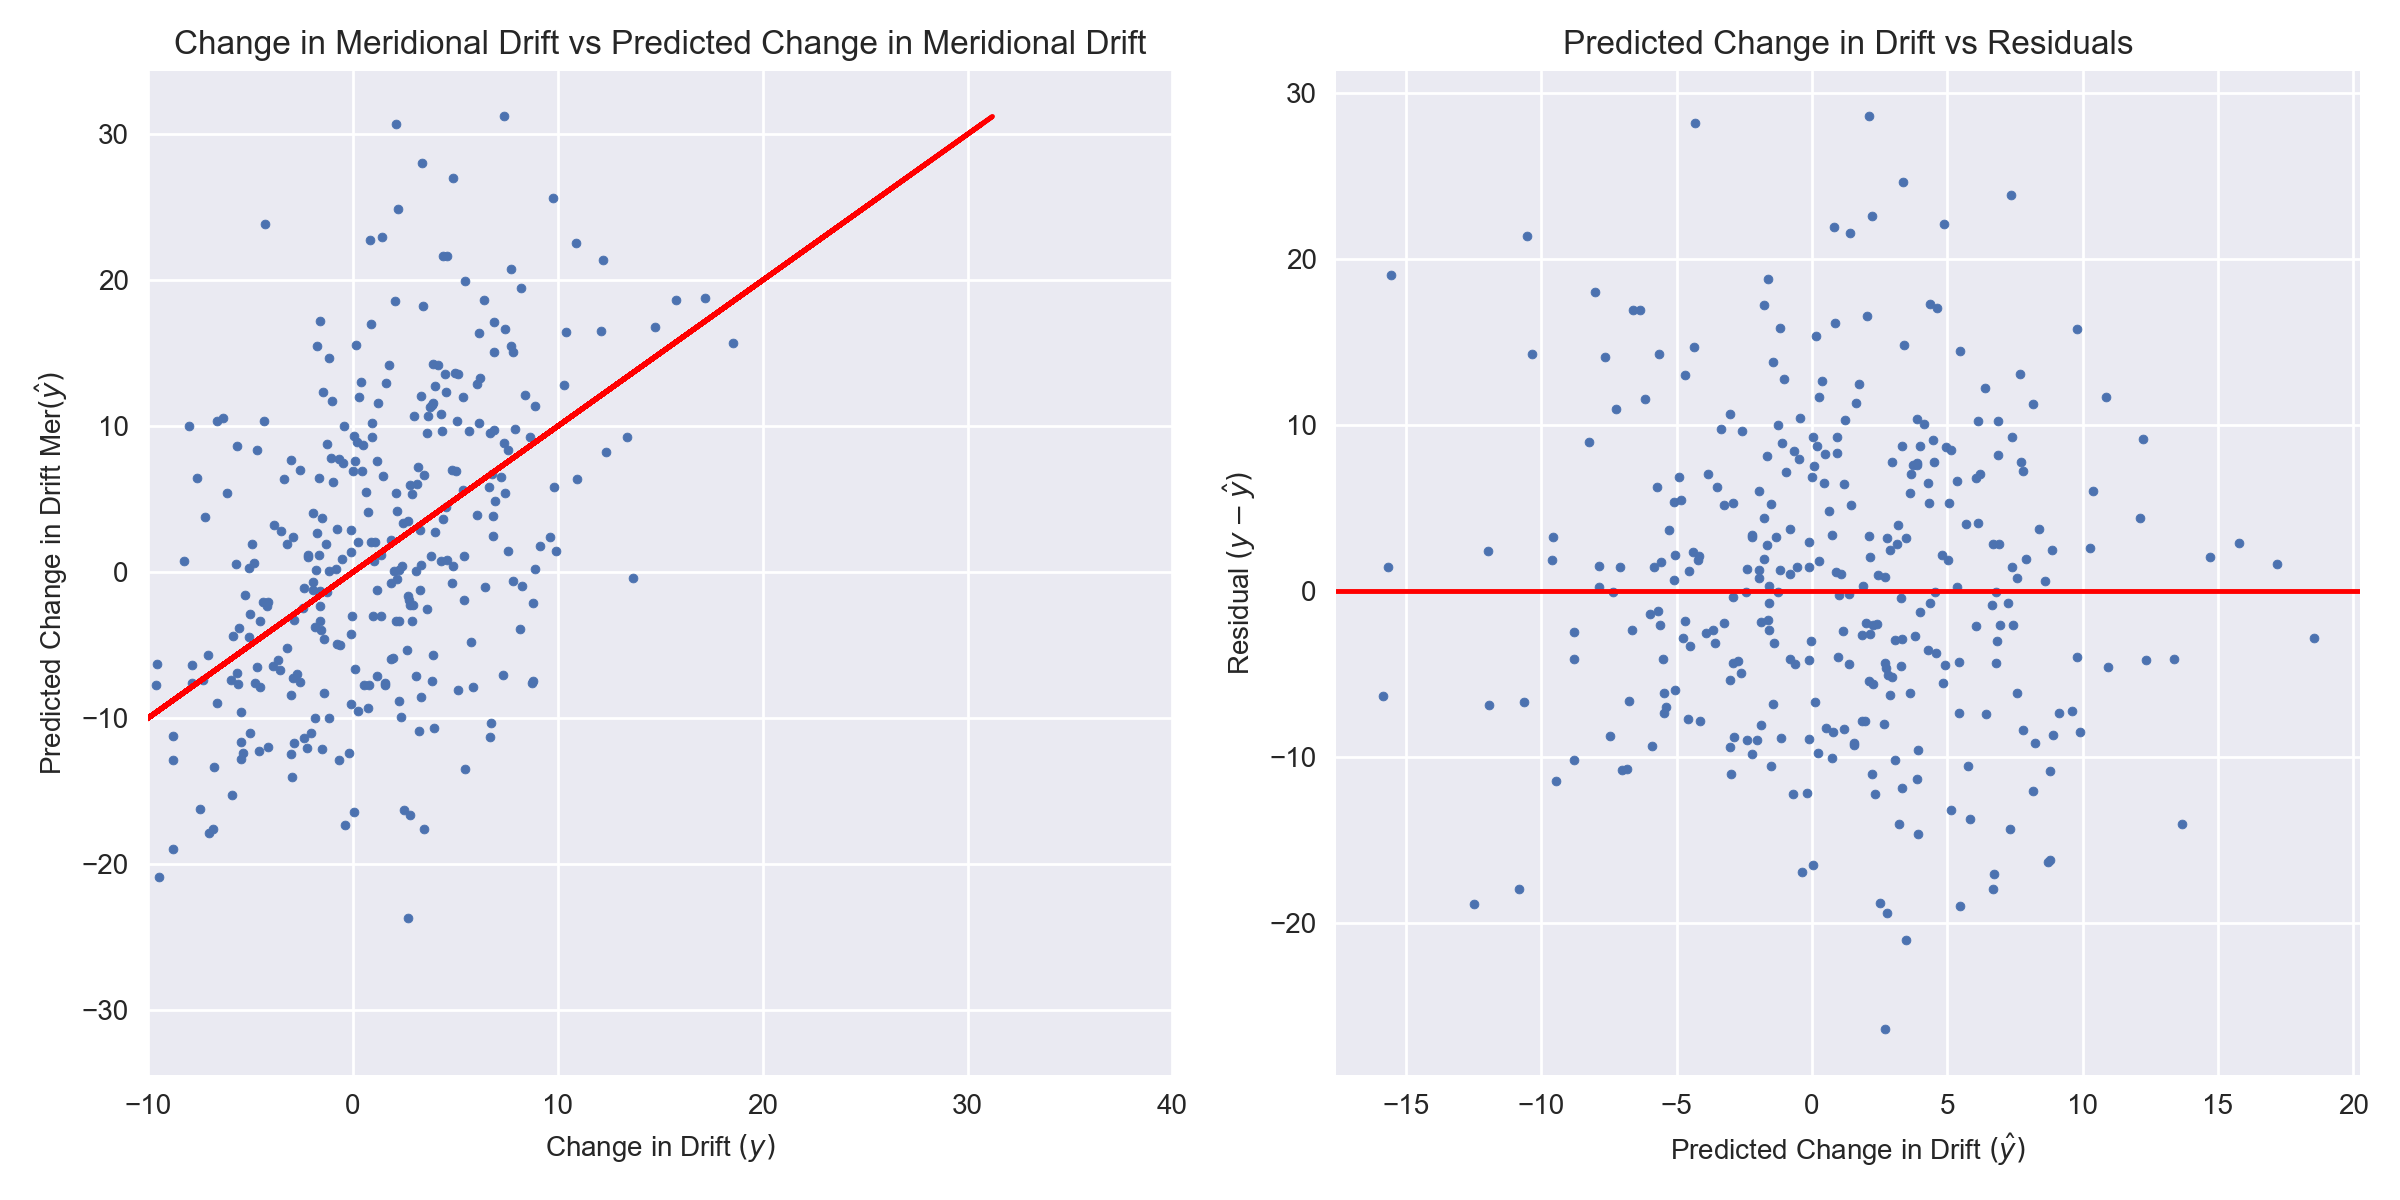

In [20]:
#NO PCA

plt.figure(figsize=(12,6))      
plt.subplot(121)                


# (1) predictions vs. observations
plt.scatter(y_pred_test , y_test, s = 10)
plt.xlabel("Change in Drift $(y)$")
plt.ylabel("Predicted Change in Drift Mer$(\hat{y})$")
plt.title("Change in Meridional Drift vs Predicted Change in Meridional Drift")
plt.plot(y_test,y_test,'r')
plt.xlim(-10,40)

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_pred_test , y_test-y_pred_test, s = 10)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Predicted Change in Drift $(\hat{y})$")
plt.title("Predicted Change in Drift vs Residuals")
plt.axhline(0,color ='red')

plt.tight_layout()
plt.savefig('nopca_correlations.png')

<IPython.core.display.Javascript object>


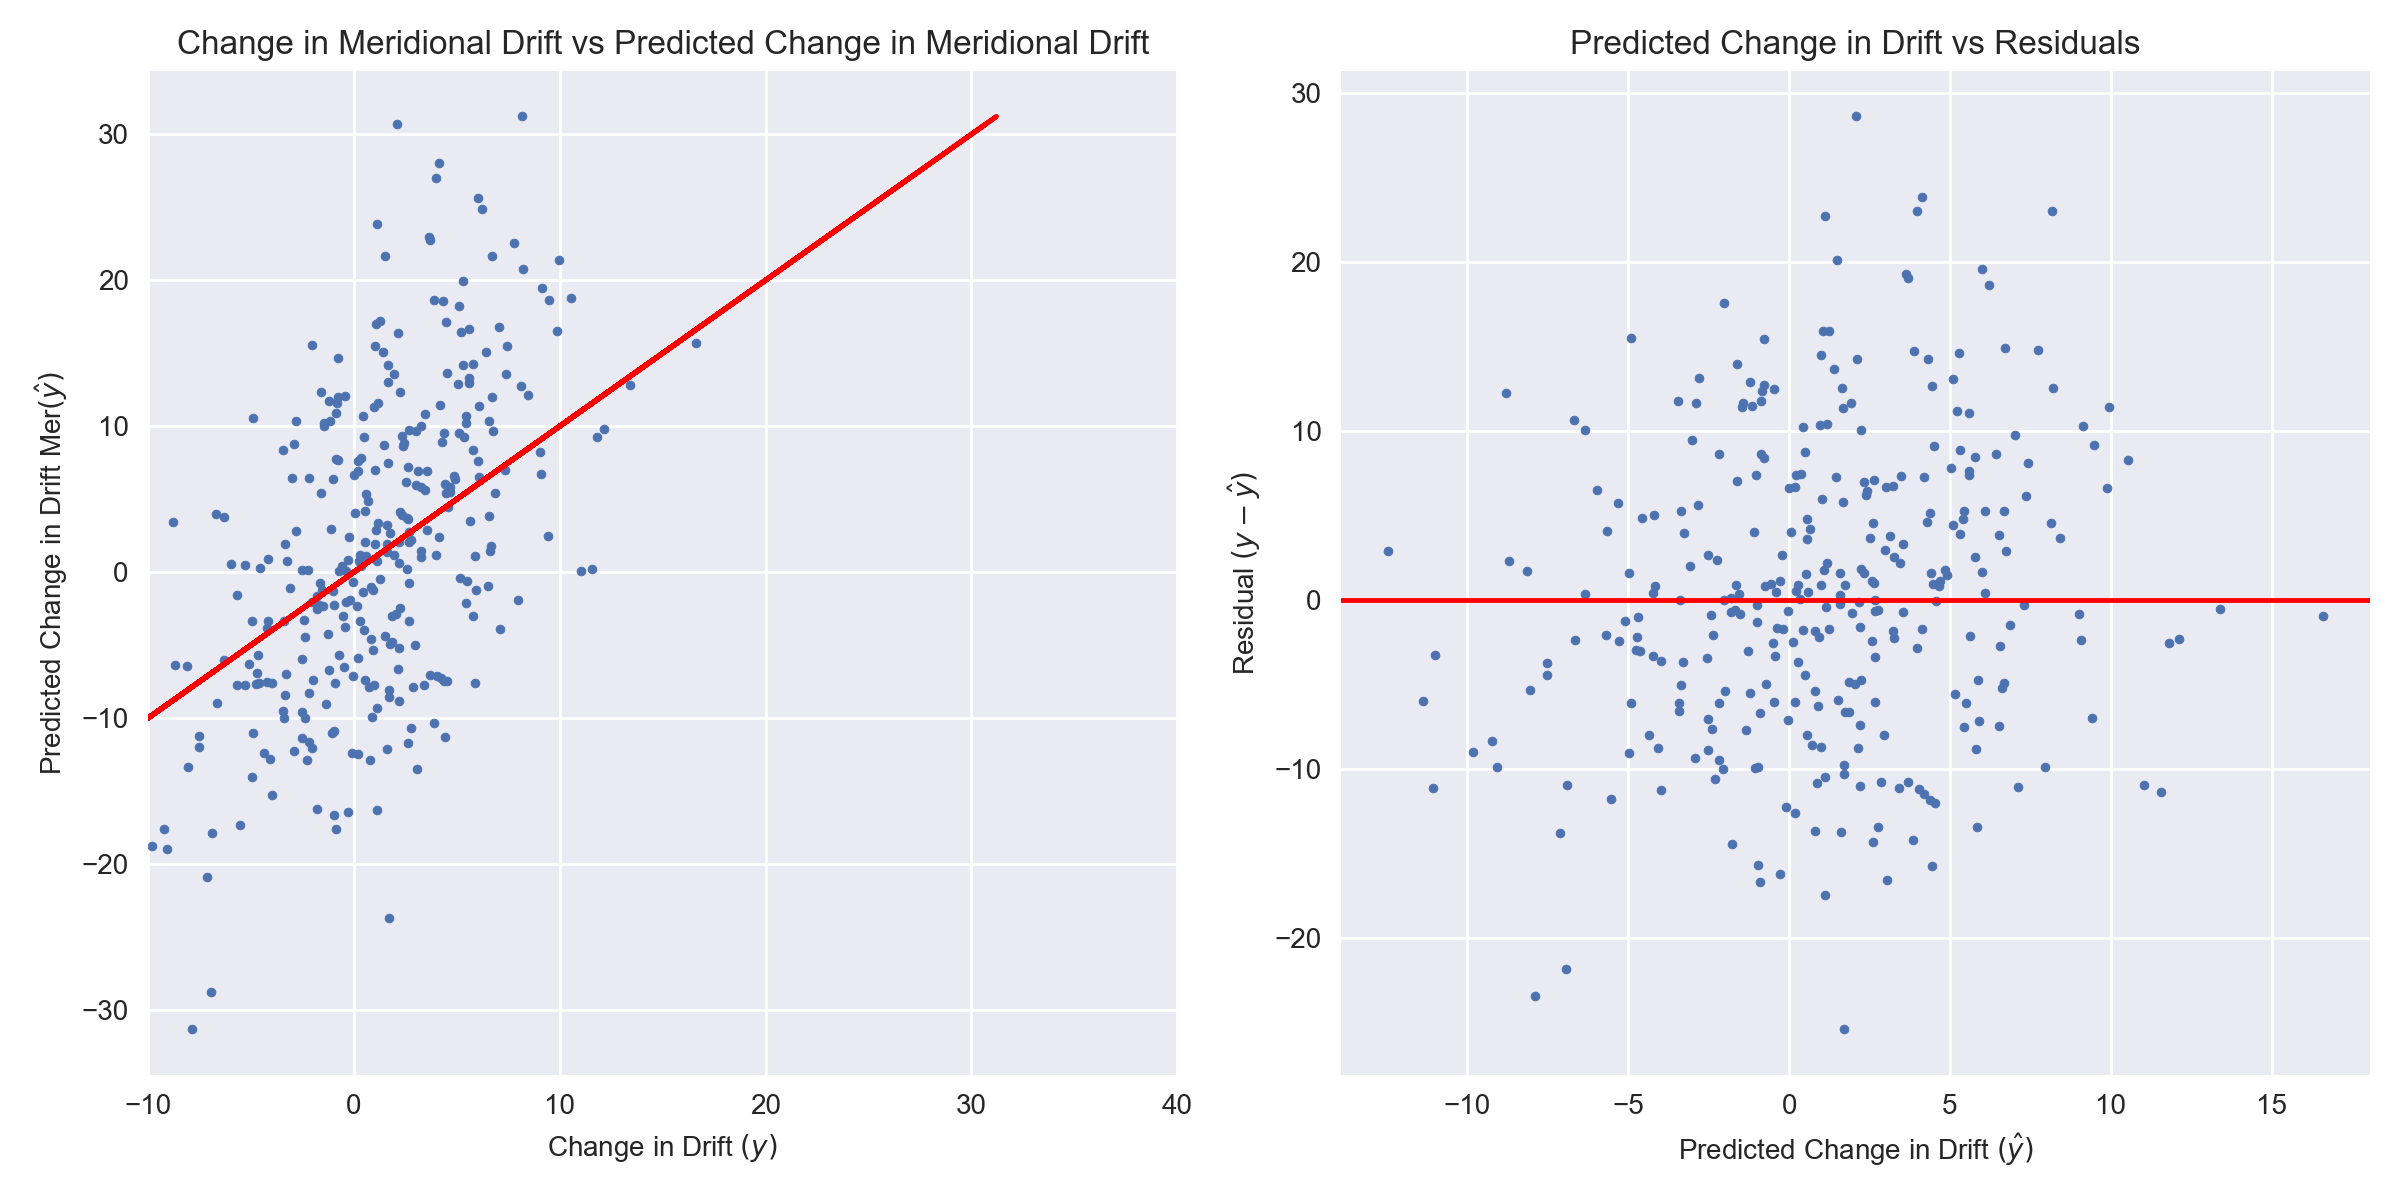

In [21]:
#PCA

plt.figure(figsize=(12,6))      
plt.subplot(121)                


# (1) predictions vs. observations
plt.scatter(y_pred_test_pca , y_test, s = 10)
plt.xlabel("Change in Drift $(y)$")
plt.ylabel("Predicted Change in Drift Mer$(\hat{y})$")
plt.title("Change in Meridional Drift vs Predicted Change in Meridional Drift")
plt.plot(y_test,y_test,'r')
plt.xlim(-10,40)

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_pred_test_pca , y_test-y_pred_test_pca, s = 10)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Predicted Change in Drift $(\hat{y})$")
plt.title("Predicted Change in Drift vs Residuals")
plt.axhline(0,color ='red')

plt.tight_layout()    
plt.savefig('pca_correlations.png')

### ERRORS

In [87]:
import random

In [88]:
#Train Test Split

train_r2s = []
test_r2s = []

for i in range(0,100):
    
    t = random.uniform(0.1,0.5)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= t)
    
    sc = StandardScaler()
    sc.fit(X_train)
    sc.fit(X_test)

    X_reduced_train = sc.transform(X_train)
    X_reduced_test = sc.transform(X_test)


    pca = PCA(n_components = 8)
    pca.fit(X_reduced_train)

    X_train_pca = pca.transform(X_reduced_train)
    X_test_pca = pca.transform(X_reduced_test)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train_pca, y_train)

    y_pred_test_pca = model.predict(X_test_pca)
    y_pred_train_pca = model.predict(X_train_pca)

    from sklearn.metrics import r2_score
    r2_train = r2_score(y_train, y_pred_train_pca)
    r2_test = r2_score(y_test, y_pred_test_pca)
    
    train_r2s.append(r2_train)
    test_r2s.append(r2_test)
    
    i+= 1

<IPython.core.display.Javascript object>


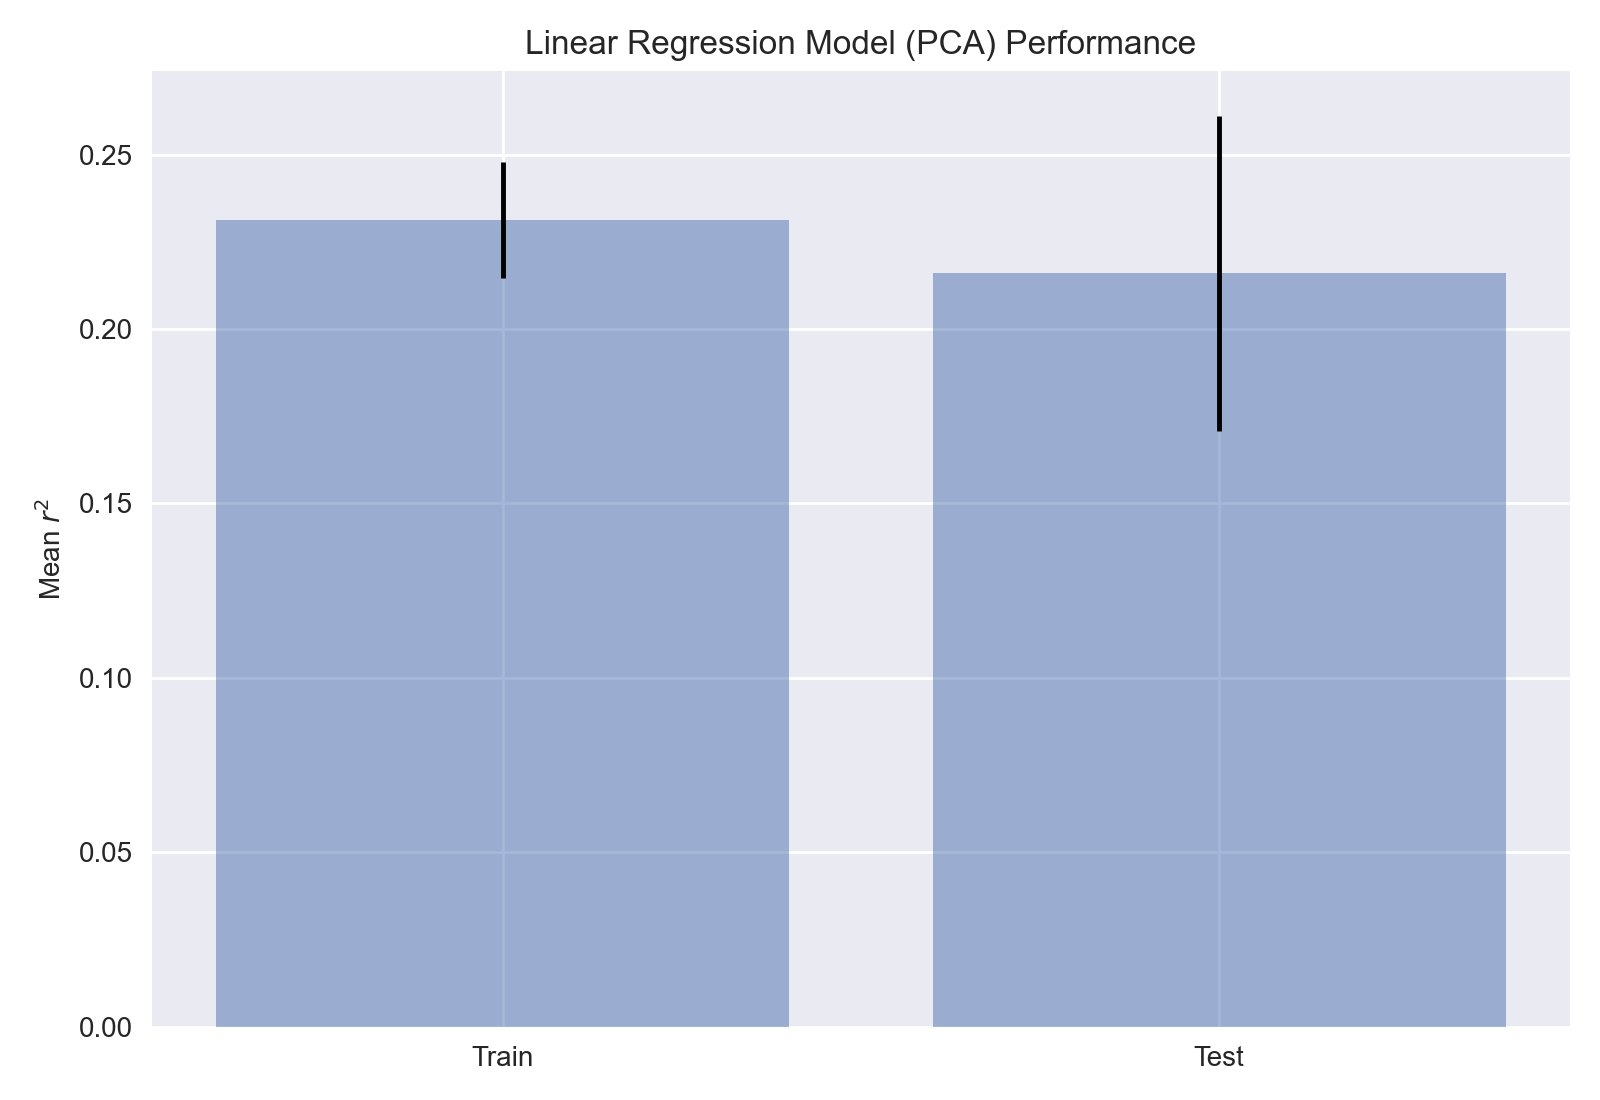

In [90]:
data_labels = ['Train','Test']
x_vals = np.arange(len(data_labels))
vals = [np.mean(train_r2s),np.mean(test_r2s)]
errs = [np.std(train_r2s),np.std(test_r2s)]

fig, ax = plt.subplots()
ax.bar(x_vals, vals, yerr=errs, align='center', alpha=0.5, ecolor='black', capsize= 10)
ax.set_ylabel('Mean $ r^2 $')
ax.set_xticks(x_vals)
ax.set_xticklabels(data_labels)
ax.set_title('Linear Regression Model (PCA) Performance')
ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('PCA_Performance.png')
plt.show()

In [91]:
vals,errs

([0.23134163590114148, 0.21597404816420343],
 [0.01666711391855563, 0.045071951065083896])

#### CHANGING PCs

In [50]:
#Train Test Split

train_means = []
test_means = []
train_stdevs = []
test_stdevs = []
n_comps = []

for n in range(1,40):
    train_r2s = []
    test_r2s = []
    
    for i in range(0,100):
        t = random.uniform(0.1,0.5)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= t)

        sc = StandardScaler()
        sc.fit(X_train)
        sc.fit(X_test)

        X_reduced_train = sc.transform(X_train)
        X_reduced_test = sc.transform(X_test)


        pca = PCA(n_components = n)
        pca.fit(X_reduced_train)

        X_train_pca = pca.transform(X_reduced_train)
        X_test_pca = pca.transform(X_reduced_test)

        model = LinearRegression(fit_intercept=True)
        model.fit(X_train_pca, y_train)

        y_pred_test_pca = model.predict(X_test_pca)
        y_pred_train_pca = model.predict(X_train_pca)

        from sklearn.metrics import r2_score
        r2_train = r2_score(y_train, y_pred_train_pca)
        r2_test = r2_score(y_test, y_pred_test_pca)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)
        
        i+= 1

    train_means.append(np.mean(train_r2s))
    train_stdevs.append(np.std(train_r2s))
    
    test_means.append(np.mean(test_r2s))
    test_stdevs.append(np.std(test_r2s))
    n_comps.append(n)
    
    train_r2s = []
    test_r2s = []
    
    
    print(n)
    n += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


<IPython.core.display.Javascript object>


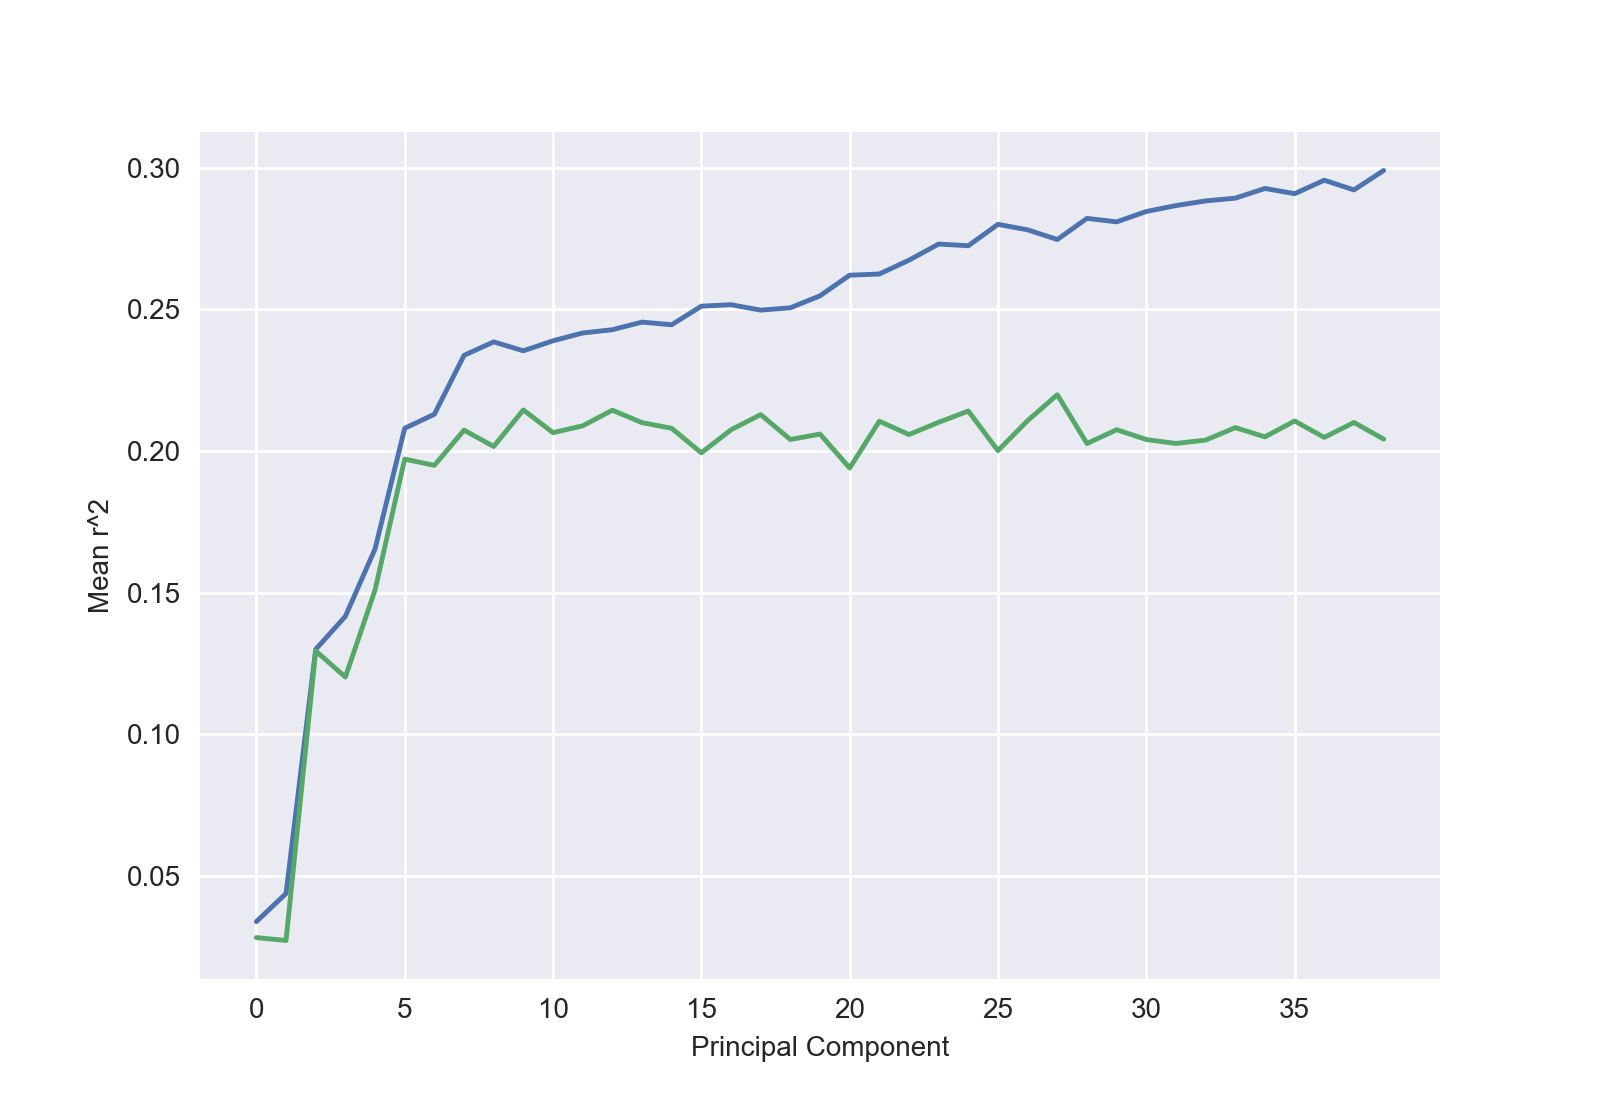

In [58]:
plt.figure()
plt.plot(train_means)
plt.plot(test_means)
plt.xlabel('Principal Component')
plt.ylabel('Mean r^2')

plt.show()

<IPython.core.display.Javascript object>


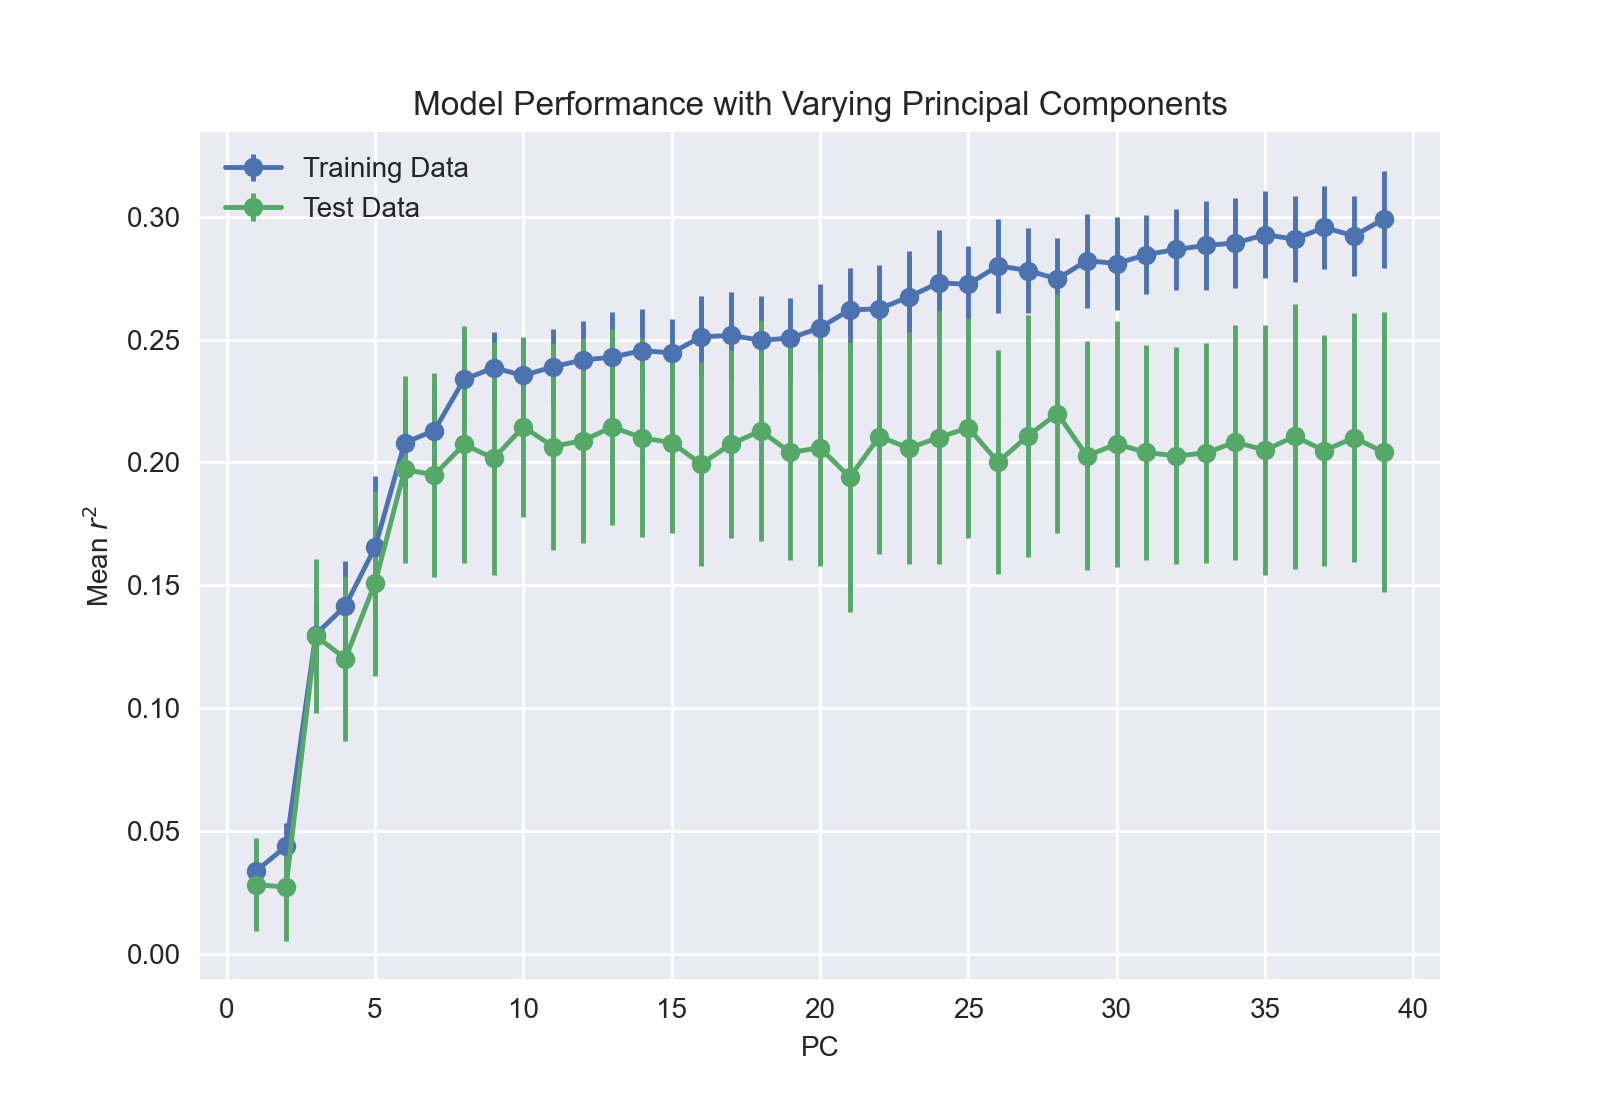

In [72]:
x = n_comps
y = train_means
y2 = test_means
yerr = train_stdevs
y2_err = test_stdevs

fig, ax = plt.subplots()


ax.errorbar(x, y,
            yerr= yerr,
            fmt='-o',label = 'Training Data')


ax.errorbar(x, y2,
            yerr= y2_err,
            fmt='-o', label = "Test Data")

ax.set_xlabel('PC')
ax.set_ylabel('Mean $ r^2 $')
ax.set_title('Model Performance with Varying Principal Components')

plt.legend()
plt.show()
plt.savefig('Model_Performance_PCs.png')


### OLD CODE

#### NO PCA

In [29]:
#NO PCA

plt.figure(figsize=(12,6))      
plt.subplot(121)                


# (1) predictions vs. observations
plt.scatter(y_pred_test , y_test, s = 10)
plt.xlabel("Change in Drift $(y)$")
plt.ylabel("Predicted Change in Drift Mer$(\hat{y})$")
plt.title("Change in Meridional Drift vs Predicted Change in Meridional Drift")
plt.plot(y_test,y_test,'r')
plt.xlim(-10,40)

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_pred_test , y_test-y_pred_test, s = 10)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Predicted Change in Drift $(\hat{y})$")
plt.title("Predicted Change in Drift vs Residuals")
plt.axhline(0,color ='red')

plt.tight_layout()             

<IPython.core.display.Javascript object>

In [39]:
# defining r_2 as a function to get r_2 to check against the SKLEARN
def r2_new(actual,pred):
    residuals = (actual-pred)
    rss = np.sum(residuals**2)
    diff = actual-np.mean(actual,axis = 0)
    tss = np.sum(diff**2)
    return (1- rss/tss)


In [40]:
r2_train = r_2(y_train, y_pred_train)
r2_test = r_2(y_test, y_pred_test)


print('r^2 for Training Set', r2_train[0])
print('r^2 for Test Set', r2_test[0])


r^2 for Training Set 0.285095220254101
r^2 for Test Set 0.31726409234779296


In [41]:
from sklearn.metrics import r2_score
r2_train_sk = r2_score(y_train, y_pred_train)
r2_test_sk = r2_score(y_test, y_pred_test)

print('r^2 for Training Set Using SKLearn', r2_train_sk)
print('r^2 for Test Set Using SKLearn', r2_test_sk)



r^2 for Training Set Using SKLearn 0.28515942680381234
r^2 for Test Set Using SKLearn 0.13549699661920078


#### PCA

<IPython.core.display.Javascript object>


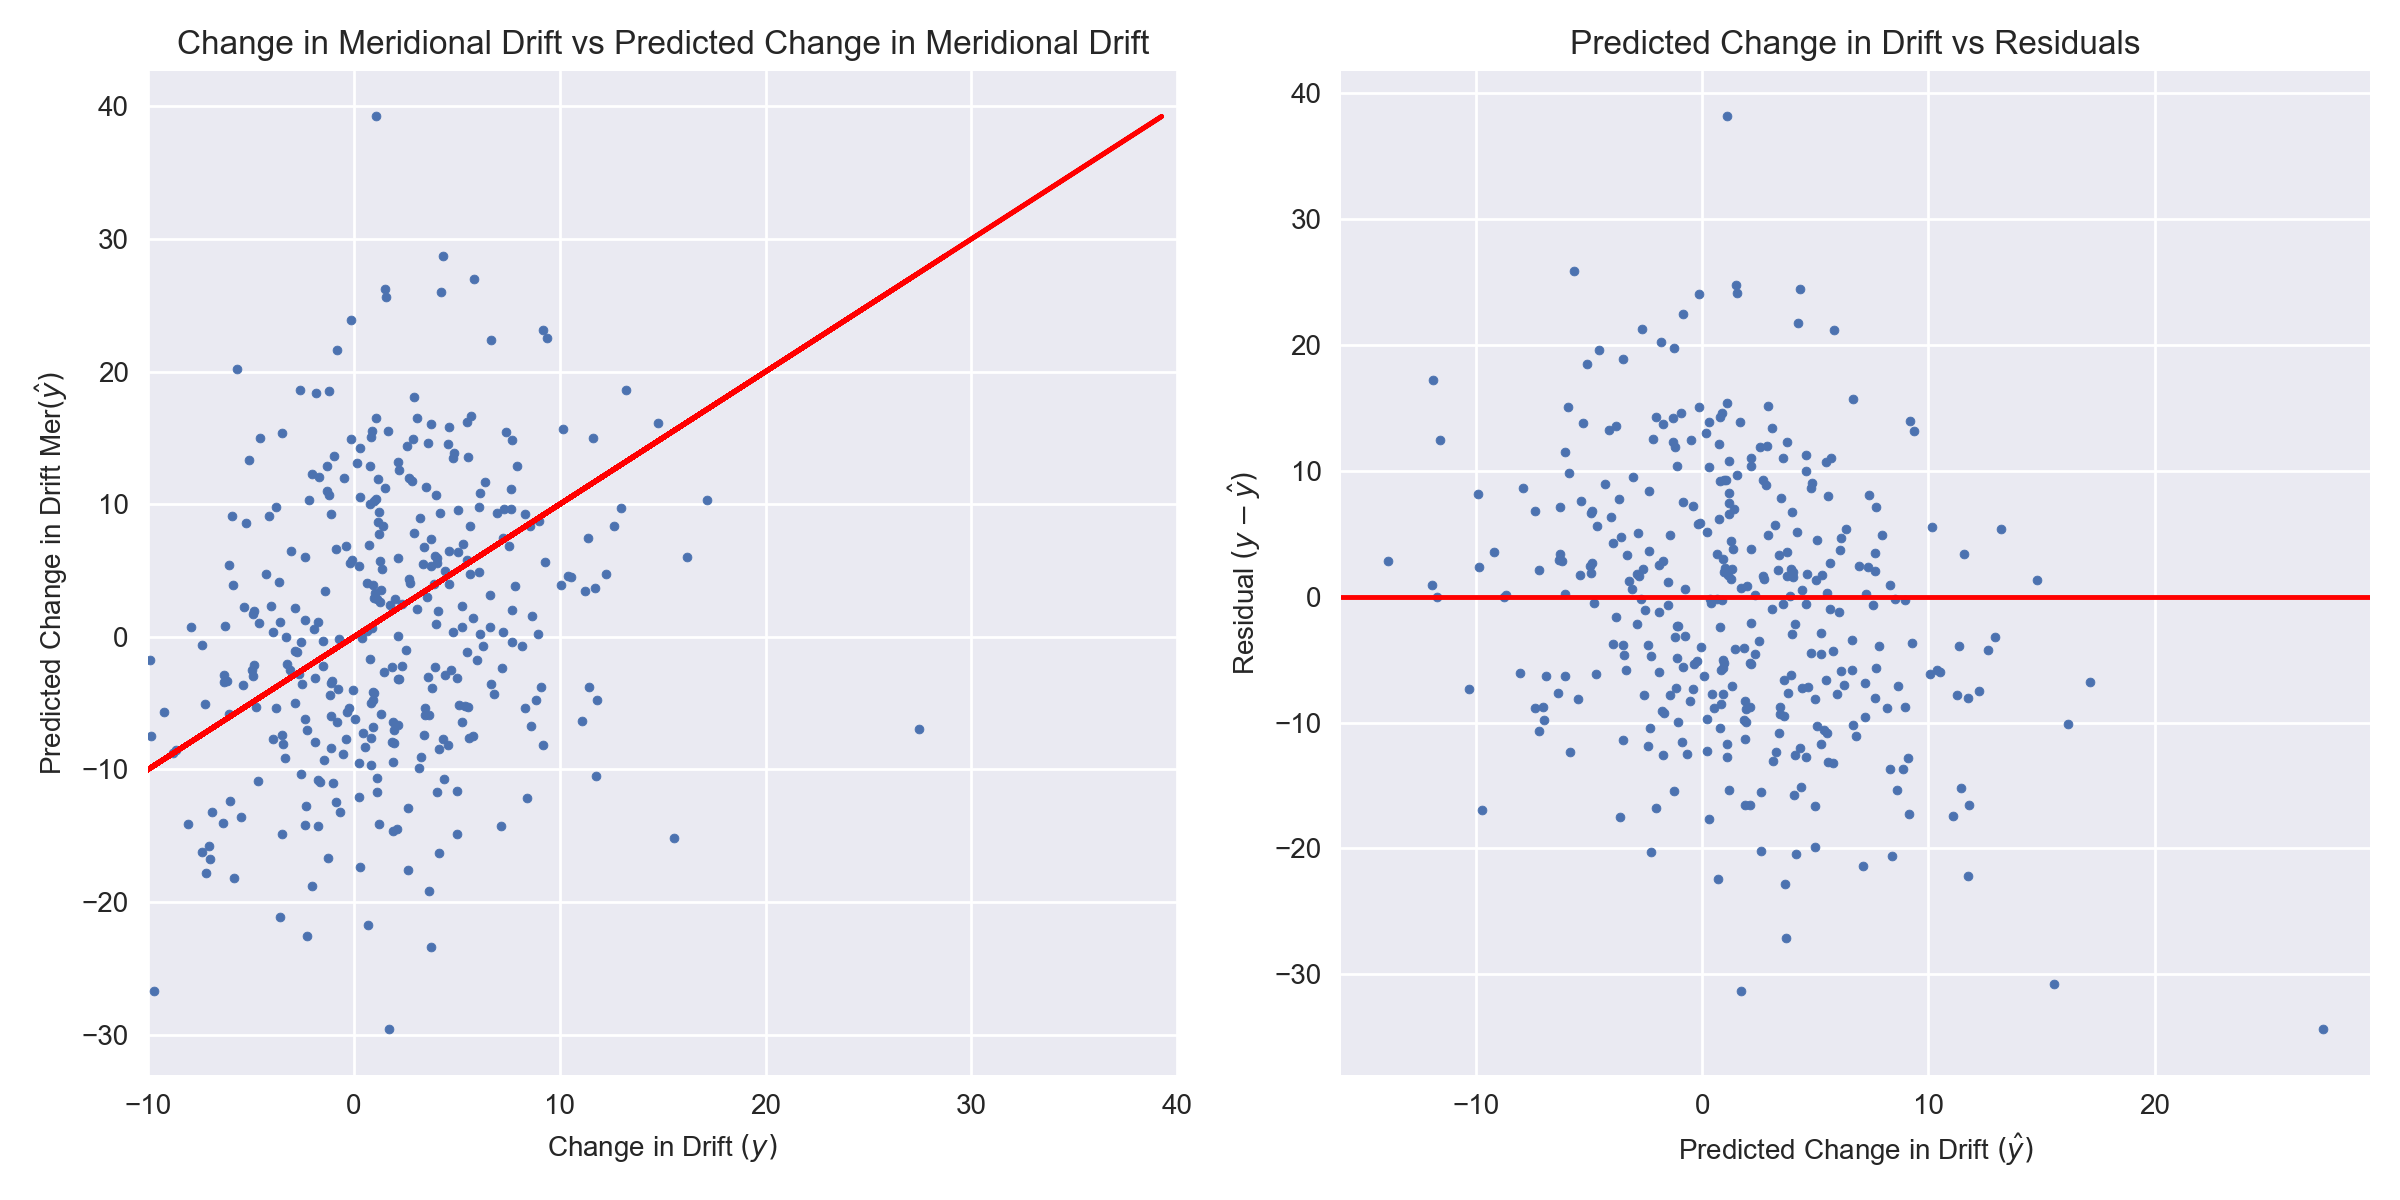

In [16]:
#PCA

plt.figure(figsize=(12,6))      
plt.subplot(121)                


# (1) predictions vs. observations
plt.scatter(y_pred_test_pca , y_test, s = 10)
plt.xlabel("Change in Drift $(y)$")
plt.ylabel("Predicted Change in Drift Mer$(\hat{y})$")
plt.title("Change in Meridional Drift vs Predicted Change in Meridional Drift")
plt.plot(y_test,y_test,'r')
plt.xlim(-10,40)

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_pred_test_pca , y_test-y_pred_test_pca, s = 10)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Predicted Change in Drift $(\hat{y})$")
plt.title("Predicted Change in Drift vs Residuals")
plt.axhline(0,color ='red')

plt.tight_layout()             

In [34]:
r2_train_pca_1 = r2_new(y_train, y_pred_train_pca)
r2_test_pca_1 = r2_new(y_test, y_pred_test_pca)


print('r^2 for Training Set (Method 1)', r2_train_pca_1[0])
print('r^2 for Test Set (Method 1)', r2_test_pca_1[0])


r^2 for Training Set (Method 1) 0.23716501276216173
r^2 for Test Set (Method 1) -0.010159126133580276


In [35]:
from sklearn.metrics import r2_score
r2_train_sk_pc = r2_score(y_train, y_pred_train_pca)
r2_test_sk_pc = r2_score(y_test, y_pred_test_pca)

print('r^2 for Training Set with SKLearn', r2_train_sk_pc)
print('r^2 for Test Set With SKLearn', r2_test_sk_pc)



r^2 for Training Set with SKLearn 0.23716501276216173
r^2 for Test Set With SKLearn -0.010159126133580276


#### R^2 VS PC COMPONENT NUMBER

In [53]:
def r2(component):
    X = df_u
    y = df_drift_mer

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    pca = PCA(n_components= component)
    X_reduced_train = pca.fit_transform(X_train)
    X_reduced_test = pca.fit_transform(X_test)
    
    lin_reg_pc = LinearRegression().fit(X_reduced_train, y_train)
    
    y_pred_test_pca = lin_reg_pc.predict(X_reduced_test)
    y_pred_train_pca = lin_reg_pc.predict(X_reduced_train)
    
    r2_train = r_2(y_train, y_pred_train_pca)
    r2_test = r_2(y_test, y_pred_test_pca)
    
    
    return r2_train,r2_test

component = []
train_r2s = []
test_r2s = []

for i in range(1,81):
    r2_val = r2(i)
    train = r2_val[0]
    test = r2_val[1]
    
    component.append(i)
    train_r2s.append(train)
    test_r2s.append(test)

In [44]:
np.array(test_r2s)-np.array(train_r2s)

array([[-0.00223754],
       [-0.00043657],
       [ 0.02736647],
       [ 0.02816163],
       [ 0.02825458],
       [ 0.02755539],
       [ 0.02755474],
       [ 0.02820073],
       [ 0.02820267],
       [ 0.02820345],
       [ 0.02820488],
       [ 0.02824051],
       [ 0.02841449],
       [ 0.0292594 ],
       [ 0.02969176],
       [ 0.0297309 ],
       [ 0.02975049],
       [ 0.02979444],
       [ 0.03118728],
       [ 0.03120631],
       [ 0.03166999],
       [ 0.03151686],
       [ 0.03153599],
       [ 0.03161896],
       [ 0.03149085],
       [ 0.03153389],
       [ 0.03156132],
       [ 0.03155232],
       [ 0.03147012],
       [ 0.03146812],
       [ 0.03153186],
       [ 0.03120265],
       [ 0.0311971 ],
       [ 0.03107005],
       [ 0.03105449],
       [ 0.03101843],
       [ 0.03101832],
       [ 0.0307857 ],
       [ 0.03087119],
       [ 0.03078996],
       [ 0.03078948],
       [ 0.03078943],
       [ 0.03081876],
       [ 0.03079107],
       [ 0.03078832],
       [ 0

<IPython.core.display.Javascript object>


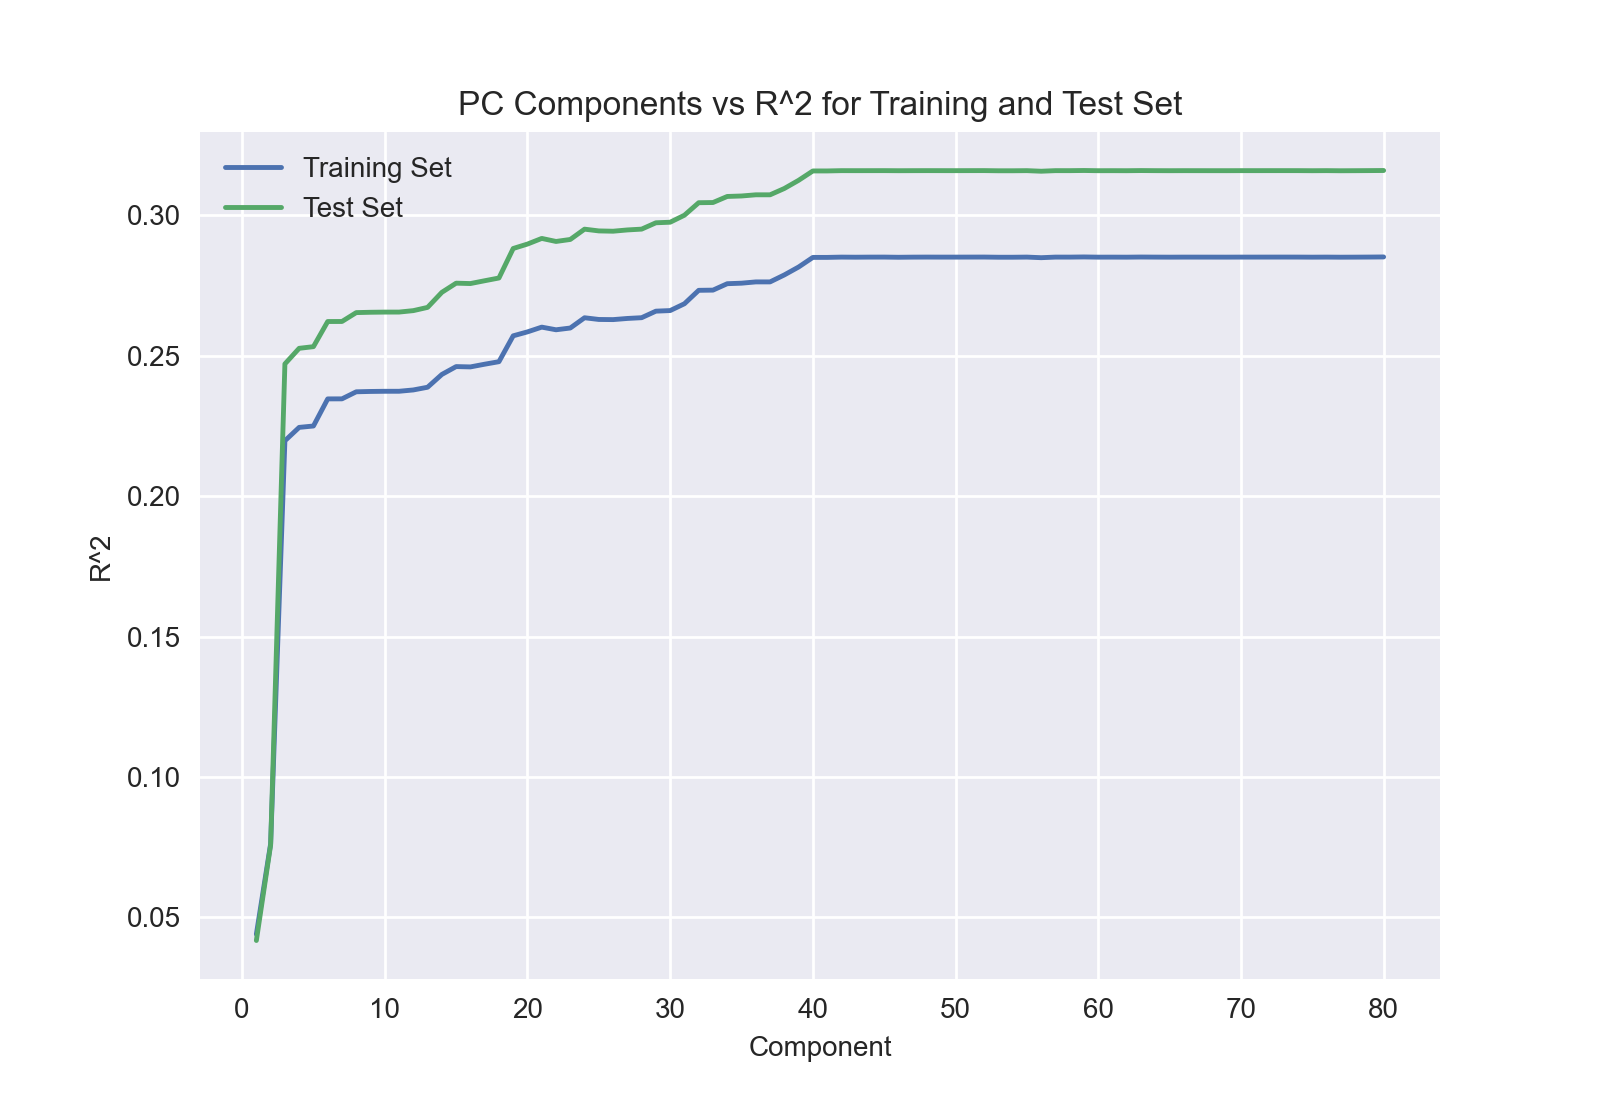

In [54]:
plt.figure()
plt.title('PC Components vs R^2 for Training and Test Set')
plt.plot(component,train_r2s,label = 'Training Set')
plt.plot(component,test_r2s, label = 'Test Set')
plt.xlabel('Component')
plt.ylabel('R^2')
plt.legend()
plt.show()

#### Components and Alts

In [23]:
X = df_u
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


pca = PCA()
X_reduced = pca.fit_transform(scale(X))


In [24]:
components = pca.components_
df_c = pd.DataFrame(components)
alts = d.alt.to_series().tolist()

dicts = {}
keys = range(len(alts))
values = alts
for i in keys:
        dicts[i] = values[i]

df_c.rename(columns= dicts)

,94.277060,97.210787,100.135368,103.050832,105.957207,108.854521,111.742804,114.622081,117.492383,120.353737,...,279.033283,281.391037,283.741441,286.084518,288.420290,290.748781,293.070012,295.384007,297.690789,299.990379
0,0.015617,1.770296e-02,1.072697e-02,-2.805272e-03,-1.971300e-02,-3.952950e-02,-5.450674e-02,-5.429580e-02,-3.890784e-02,-2.547437e-02,...,-0.122366,-0.110871,-0.110418,-0.116833,-0.110871,-0.097220,-0.094053,-0.104451,-0.107300,-0.095492
1,-0.016054,-1.700460e-02,-1.453683e-02,-2.636274e-02,-3.579689e-02,-2.272797e-02,1.823832e-02,7.643204e-02,1.055025e-01,1.222968e-01,...,0.096979,0.090057,0.091422,0.098161,0.094495,0.084026,0.080570,0.085785,0.083674,0.069755
2,0.031987,7.087597e-02,8.831579e-02,9.317351e-02,9.569236e-02,9.778970e-02,7.316797e-02,2.331623e-02,-3.009094e-02,-1.080214e-01,...,-0.094751,-0.088889,-0.091755,-0.100895,-0.099325,-0.090203,-0.086780,-0.090482,-0.085849,-0.068885
3,-0.071662,-1.515651e-01,-2.146397e-01,-2.155570e-01,-1.405284e-01,-9.617641e-03,1.368666e-01,2.744705e-01,3.351738e-01,3.237322e-01,...,-0.133522,-0.137943,-0.158065,-0.194397,-0.209988,-0.206284,-0.196388,-0.176885,-0.132042,-0.064937
4,-0.278204,-2.909200e-01,-1.651449e-01,6.510246e-02,2.713213e-01,3.940310e-01,4.072325e-01,2.932739e-01,1.606798e-01,6.772115e-02,...,-0.029009,-0.021618,0.013782,0.087684,0.151898,0.192838,0.207669,0.201645,0.172218,0.116295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.000000,1.931075e-16,-4.271755e-16,3.470574e-16,2.773583e-16,-3.251995e-16,1.685782e-17,6.430630e-17,-9.101021e-17,2.271497e-16,...,-0.059205,0.085478,-0.349990,0.492277,-0.199009,-0.079784,0.050701,0.037857,-0.083873,0.041447
76,-0.000000,1.492480e-16,-1.304598e-16,1.938780e-16,-3.623296e-16,6.846806e-16,-2.636187e-16,-6.410866e-17,-6.550634e-17,-3.798457e-17,...,-0.030341,-0.005427,-0.169168,0.230243,0.112837,-0.217861,0.053949,0.019492,-0.080428,0.045705
77,-0.000000,-4.529491e-17,1.932303e-16,-2.802655e-16,-2.552967e-17,3.010486e-16,-1.838231e-17,-2.021972e-16,1.236036e-16,-9.964137e-17,...,0.013469,-0.087723,0.075002,0.172230,-0.140987,-0.291879,0.169750,0.230922,-0.110681,-0.025449
78,-0.000000,-2.252356e-16,2.606448e-16,-1.560013e-16,2.200150e-16,-2.694180e-16,-6.957807e-17,1.405007e-16,-6.897337e-17,-5.870935e-18,...,0.016933,0.007558,-0.098293,0.169345,0.001466,-0.034714,0.009808,-0.103905,0.078929,-0.018367


<IPython.core.display.Javascript object>


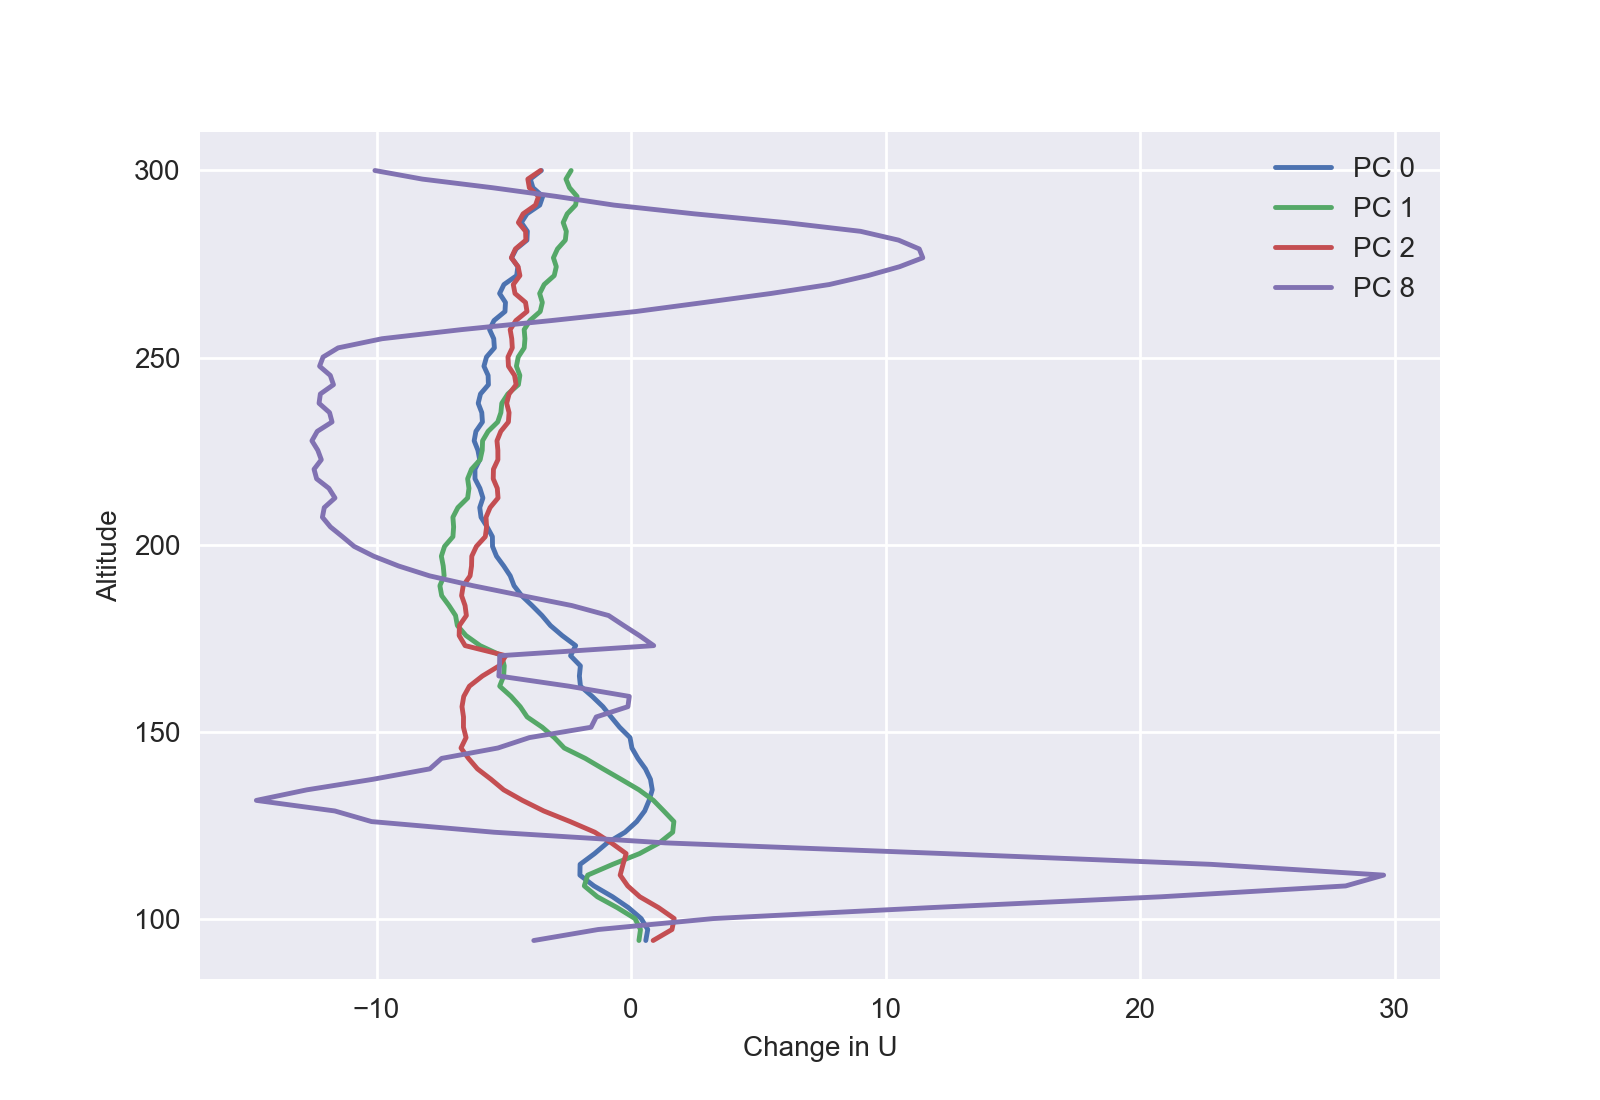

In [42]:
#INITIAL MATRICES
u_changes = df_u
pc_components = df_c
    
#WEIGHTS
weights =  np.dot(u_changes, pc_components)
weights_df = pd.DataFrame(weights)
    
#PCs
total_pc = 0
pc_list = []
    
for i in np.arange(len(pc_components)):
    w = weights_df[0][i] 
    pc = pc_components.loc[i,:]
    total_pc = total_pc + (w*pc)
    pc_list.append(total_pc)

#PLOTTING

plt.figure()
#plt.plot(profile,d.alt, label = 'Original Data')
plt.plot(pc_list[0], d.alt , label = 'PC 0')
plt.plot(pc_list[1], d.alt , label = 'PC 1')
plt.plot(pc_list[2], d.alt , label = 'PC 2')
plt.plot(pc_list[8], d.alt , label = 'PC 8')
#plt.plot(pc_list[20], d.alt , label = 'PC 20')
#plt.plot(pc_list[79], d.alt , label = 'PC 79')
plt.legend()
plt.xlabel('Change in U')
plt.ylabel('Altitude')
plt.show()

In [50]:
pc_components

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.015617,1.770296e-02,1.072697e-02,-2.805272e-03,-1.971300e-02,-3.952950e-02,-5.450674e-02,-5.429580e-02,-3.890784e-02,-2.547437e-02,...,-0.122366,-0.110871,-0.110418,-0.116833,-0.110871,-0.097220,-0.094053,-0.104451,-0.107300,-0.095492
1,-0.016054,-1.700460e-02,-1.453683e-02,-2.636274e-02,-3.579689e-02,-2.272797e-02,1.823832e-02,7.643204e-02,1.055025e-01,1.222968e-01,...,0.096979,0.090057,0.091422,0.098161,0.094495,0.084026,0.080570,0.085785,0.083674,0.069755
2,0.031987,7.087597e-02,8.831579e-02,9.317351e-02,9.569236e-02,9.778970e-02,7.316797e-02,2.331623e-02,-3.009094e-02,-1.080214e-01,...,-0.094751,-0.088889,-0.091755,-0.100895,-0.099325,-0.090203,-0.086780,-0.090482,-0.085849,-0.068885
3,-0.071662,-1.515651e-01,-2.146397e-01,-2.155570e-01,-1.405284e-01,-9.617641e-03,1.368666e-01,2.744705e-01,3.351738e-01,3.237322e-01,...,-0.133522,-0.137943,-0.158065,-0.194397,-0.209988,-0.206284,-0.196388,-0.176885,-0.132042,-0.064937
4,-0.278204,-2.909200e-01,-1.651449e-01,6.510246e-02,2.713213e-01,3.940310e-01,4.072325e-01,2.932739e-01,1.606798e-01,6.772115e-02,...,-0.029009,-0.021618,0.013782,0.087684,0.151898,0.192838,0.207669,0.201645,0.172218,0.116295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.000000,1.931075e-16,-4.271755e-16,3.470574e-16,2.773583e-16,-3.251995e-16,1.685782e-17,6.430630e-17,-9.101021e-17,2.271497e-16,...,-0.059205,0.085478,-0.349990,0.492277,-0.199009,-0.079784,0.050701,0.037857,-0.083873,0.041447
76,-0.000000,1.492480e-16,-1.304598e-16,1.938780e-16,-3.623296e-16,6.846806e-16,-2.636187e-16,-6.410866e-17,-6.550634e-17,-3.798457e-17,...,-0.030341,-0.005427,-0.169168,0.230243,0.112837,-0.217861,0.053949,0.019492,-0.080428,0.045705
77,-0.000000,-4.529491e-17,1.932303e-16,-2.802655e-16,-2.552967e-17,3.010486e-16,-1.838231e-17,-2.021972e-16,1.236036e-16,-9.964137e-17,...,0.013469,-0.087723,0.075002,0.172230,-0.140987,-0.291879,0.169750,0.230922,-0.110681,-0.025449
78,-0.000000,-2.252356e-16,2.606448e-16,-1.560013e-16,2.200150e-16,-2.694180e-16,-6.957807e-17,1.405007e-16,-6.897337e-17,-5.870935e-18,...,0.016933,0.007558,-0.098293,0.169345,0.001466,-0.034714,0.009808,-0.103905,0.078929,-0.018367


In [49]:
u_changes

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,126.221382,6.091295,2.758862,-14.940486,-15.371595,-11.957402,-4.856908,-61.107597,22.700260,28.159544,...,-20.251367,-18.918155,-17.929439,-17.320773,-16.714004,-16.109127,-14.023296,-10.121167,-6.231204,-2.353367
1,55.951002,58.068511,24.181075,-56.006532,21.616283,-15.907028,0.836305,-36.686277,-34.947794,3.788452,...,11.517584,25.633769,34.848590,38.654617,42.448779,46.231114,40.967876,24.616149,8.315398,-7.934537
2,-87.252663,27.694339,63.928431,38.568724,43.764846,41.207163,73.197271,67.666153,44.883293,60.049980,...,23.077923,36.800083,38.975264,28.401476,17.860652,7.352688,-0.201705,-4.142098,-8.070206,-11.986070
3,49.266178,38.853897,25.929757,-8.266624,-40.623964,-50.699713,-6.303042,23.624407,-35.322672,6.525582,...,31.855707,51.683786,58.081955,49.653518,41.251356,32.875388,29.171497,31.190270,33.202749,35.208954
4,50.051284,3.383523,7.355206,19.019079,0.645595,-26.656854,-37.507926,-41.825795,-52.838610,-13.510464,...,-27.116850,-20.301491,-10.961514,1.169176,13.262048,25.317221,24.591390,8.202796,-8.134706,-24.421277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,46.485234,20.202256,-4.133196,-9.960455,8.211468,85.374328,99.816027,23.669067,-61.154182,-90.388087,...,-0.308203,-7.935946,-9.438779,-4.179245,1.063893,6.290685,8.676183,7.581572,6.490374,5.402578
1157,54.182358,41.586132,-16.669493,-43.634285,-10.683799,21.258191,53.013611,39.177949,16.404002,18.992216,...,12.997550,9.651920,9.672310,13.409325,17.134690,20.848442,21.974790,19.931259,17.894098,15.863288
1158,-12.495078,-22.764614,-39.903827,-54.955758,-31.748170,-1.355824,-28.690046,-53.144782,-48.080377,-18.827789,...,7.797754,8.480714,12.453728,20.060818,27.644193,35.203927,37.189774,32.346626,27.518577,22.705578
1159,-37.249705,-18.287356,16.840027,38.397462,51.485381,-3.772723,-30.684593,-30.841193,15.767484,20.112259,...,-38.088278,-41.952884,-40.565864,-33.379752,-26.216042,-19.074664,-14.187559,-12.059418,-9.937912,-7.823019


In [51]:
pc_list

[0     0.576580
 1     0.653596
 2     0.396041
 3    -0.103571
 4    -0.727807
         ...   
 75   -3.589372
 76   -3.472468
 77   -3.856360
 78   -3.961521
 79   -3.525566
 Name: 0, Length: 80, dtype: float64,
 0     0.307700
 1     0.368793
 2     0.152570
 3    -0.545109
 4    -1.327353
         ...   
 75   -2.182061
 76   -2.123029
 77   -2.419587
 78   -2.560103
 79   -2.357271
 Length: 80, dtype: float64,
 0     0.865913
 1     1.605682
 2     1.693808
 3     1.080903
 4     0.342617
         ...   
 75   -3.756241
 76   -3.637466
 77   -3.998625
 78   -4.058288
 79   -3.559415
 Length: 80, dtype: float64,
 0     2.069864
 1     4.152050
 2     5.299860
 3     4.702365
 4     2.703562
         ...   
 75   -0.290575
 76   -0.338060
 77   -1.026876
 78   -1.839911
 79   -2.468450
 Length: 80, dtype: float64,
 0    -11.309746
 1     -9.839087
 2     -2.642409
 3      7.833320
 4     15.752142
         ...    
 75     8.983545
 76     9.649299
 77     8.670787
 78     6.442538
 